In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

# Ìè∞Ìä∏ Í¥ÄÎ†® Í≤ΩÍ≥† Î©îÏãúÏßÄ Ïà®Í∏∞Í∏∞
warnings.filterwarnings("ignore", category=UserWarning)
import matplotlib as mpl
mpl.rcParams['font.family'] = 'sans-serif'

In [2]:
import os

os.path.abspath(os.curdir)

In [ ]:
cur_dir = os.path.abspath(os.curdir)
data_dir = f"{cur_dir}/Modulabs_MainProject5"
files = [
    "orders.csv",
    "order_products__train.csv",
    "order_products__prior.csv",
    "df_products.csv"
]

df_orders, df_train, df_prior, df_products = [pd.read_csv(f"{data_dir}/{file}") for file in files]

### 1. ÏÇ¨Ïö©Ïûê Íµ¨Îß§ Ìå®ÌÑ¥ Í∏∞Î∞ò PCA + ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ

In [3]:
df_orders["days_since_prior_order"] = df_orders["days_since_prior_order"].fillna(999)


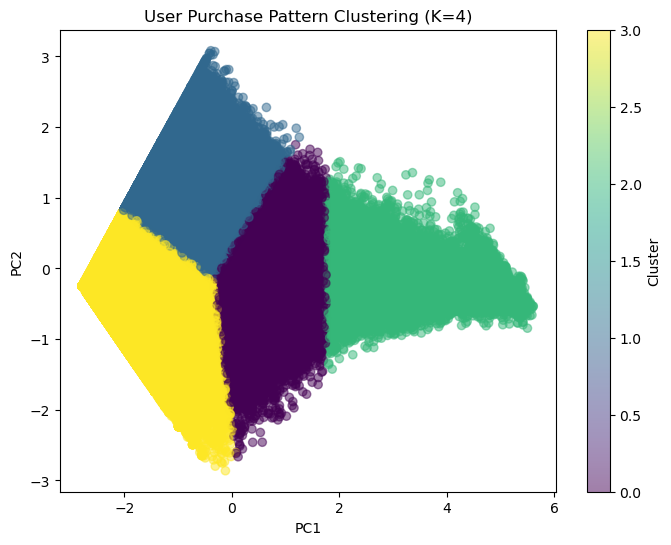

array([0, 0, 0, ..., 0, 2, 0])

In [14]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# -------------------------
# 1. ÏÇ¨Ïö©Ïûê Íµ¨Îß§ Ìå®ÌÑ¥ Í∏∞Î∞ò PCA + ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ
# -------------------------


# ‚úÖ 999Ïù∏ days_since_prior_order Í∞í Ï†úÏô∏
df_orders_filtered = df_orders[df_orders["days_since_prior_order"] != 999]

# ‚úÖ ÏÇ¨Ïö©ÏûêÎ≥Ñ Ï£ºÎ¨∏ ÌÜµÍ≥Ñ Í≥ÑÏÇ∞
user_order_stats = df_orders_filtered.groupby("user_id").agg({
    "order_number": "max",  # Ï¥ù Ï£ºÎ¨∏ ÌöüÏàò
    "days_since_prior_order": "mean"  # ÌèâÍ∑† Ï£ºÎ¨∏ Í∞ÑÍ≤©
})

# ‚úÖ df_priorÏóê user_id Ï∂îÍ∞Ä (df_ordersÏôÄ Î≥ëÌï©)
df_prior_merge = df_prior.merge(df_orders[['order_id', 'user_id']], on='order_id', how='left')

# ‚úÖ ÏÇ¨Ïö©ÏûêÎ≥Ñ Ïû¨Íµ¨Îß§Ïú® Í≥ÑÏÇ∞ (user_id Í∏∞Ï§Ä)
user_reorder_stats = df_prior_merge.groupby("user_id")["reordered"].mean().reset_index()
user_reorder_stats = user_reorder_stats.rename(columns={"reordered": "reorder_rate"})

# ‚úÖ Îç∞Ïù¥ÌÑ∞ Î≥ëÌï© (user_id Í∏∞Ï§Ä)
user_features = user_order_stats.merge(user_reorder_stats, on="user_id", how="left").fillna(0)

# ‚úÖ Îç∞Ïù¥ÌÑ∞ ÌëúÏ§ÄÌôî
scaler = StandardScaler()
user_features_scaled = scaler.fit_transform(user_features.iloc[:, 1:])  # user_id Ï†úÏô∏

# ‚úÖ PCA Ï†ÅÏö© (Ï∞®Ïõê Ï∂ïÏÜå)
pca = PCA(n_components=2)
user_pca = pca.fit_transform(user_features_scaled)

# ‚úÖ K-Means ÌÅ¥Îü¨Ïä§ÌÑ∞ Í∞úÏàò ÏµúÏ†ÅÌôî: n_clusters=3,4,5 ÎπÑÍµê
optimal_k = [3, 4, 5]
cluster_results = {}

for k in optimal_k:
    kmeans = KMeans(n_clusters=k, random_state=42,n_init=10)
    clusters = kmeans.fit_predict(user_pca)
    cluster_results[k] = clusters

# ‚úÖ ÏµúÏ†Å ÌÅ¥Îü¨Ïä§ÌÑ∞ Í∞úÏàò ÏÑ†ÌÉù (Í∏∞Î≥∏Ï†ÅÏúºÎ°ú n=4 ÏÇ¨Ïö©)
selected_k = 4
user_clusters = cluster_results[selected_k]

# ‚úÖ ÌÅ¥Îü¨Ïä§ÌÑ∞ Í≤∞Í≥º Ï†ÄÏû•
user_features["cluster"] = user_clusters

# ‚úÖ ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8, 6))
plt.scatter(user_pca[:, 0], user_pca[:, 1], c=user_clusters, cmap='viridis', alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"User Purchase Pattern Clustering (K={selected_k})")
plt.colorbar(label="Cluster")
plt.show()

# ‚úÖ ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ Í≤∞Í≥º ÌôïÏù∏
user_clusters


### **üîç ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ Í≤∞Í≥º Ìï¥ÏÑù**
Ïù¥Ï†ú ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅÏù¥ **Ïù¥ÏÉÅÏ†ÅÏù∏ ÌòïÌÉúÎ°ú Í∞úÏÑ†**ÎêòÏóàÏäµÎãàÎã§! üöÄ  
PCAÎ°ú Ï∞®Ïõê Ï∂ïÏÜåÎêú Îç∞Ïù¥ÌÑ∞Î•º ÏãúÍ∞ÅÌôîÌïú Í∑∏ÎûòÌîÑÏóêÏÑú **4Í∞úÏùò ÌÅ¥Îü¨Ïä§ÌÑ∞(K=4)**Í∞Ä Ïûò Íµ¨Î∂ÑÎêú Í≤ÉÏùÑ Î≥º Ïàò ÏûàÏäµÎãàÎã§.  

---

### **üìå 1. ÌÅ¥Îü¨Ïä§ÌÑ∞Ïùò Î∂ÑÌè¨**
1. **Î≥¥ÎùºÏÉâ(Cluster 0)**  
   - Ï§ëÏã¨Î∂ÄÏóê Î∂ÑÌè¨ÌïòÎ©∞ Îã§Î•∏ ÌÅ¥Îü¨Ïä§ÌÑ∞ÏôÄÏùò Í≤ΩÍ≥Ñ Ïó≠Ìï†ÏùÑ Ìï®  
   - ÌèâÍ∑†Ï†ÅÏù∏ Íµ¨Îß§ Ìå®ÌÑ¥ÏùÑ Í∞ÄÏßÑ ÏÇ¨Ïö©Ïûê Í∑∏Î£πÏùº Í∞ÄÎä•ÏÑ±Ïù¥ ÎÜíÏùå  

2. **Ï≤≠Î°ùÏÉâ(Cluster 1)**  
   - Ïò§Î•∏Ï™ΩÏúºÎ°ú ÎÑìÍ≤å ÌçºÏ†∏ ÏûàÏùå ‚Üí **PC1 Í∞íÏù¥ ÎÜíÏùå (Ï£ºÎ¨∏ ÌöüÏàò, Ïû¨Íµ¨Îß§Ïú® ÎÜíÏùÑ Í∞ÄÎä•ÏÑ±)**  
   - **ÏûêÏ£º Íµ¨Îß§ÌïòÎäî Í≥†Í∞ùÏ∏µ**Ïùº Í∞ÄÎä•ÏÑ±Ïù¥ ÌÅº (VIP Í≥†Í∞ùÏùº Í∞ÄÎä•ÏÑ±)  

3. **ÌååÎûÄÏÉâ(Cluster 2)**  
   - ÏôºÏ™Ω ÏÉÅÎã®Ïóê ÏúÑÏπò ‚Üí **PC1Í≥º PC2Í∞Ä ÏùåÏàòÏù∏ ÏòÅÏó≠**  
   - Íµ¨Îß§ ÌöüÏàòÍ∞Ä Ï†ÅÍ±∞ÎÇò, ÌäπÏ†ï ÏöîÏùº/ÏãúÍ∞ÑÎåÄÏóêÎßå Ï£ºÎ¨∏ÌïòÎäî Ìå®ÌÑ¥ÏùÑ Î≥¥Ïùº Ïàò ÏûàÏùå  

4. **ÎÖ∏ÎûÄÏÉâ(Cluster 3)**  
   - ÏôºÏ™Ω ÌïòÎã®ÏúºÎ°ú ÌôïÏû•Îê® ‚Üí **PC1Ïù¥ ÎÇÆÍ≥†, PC2ÎèÑ ÏÉÅÎåÄÏ†ÅÏúºÎ°ú ÎÇÆÏùå**  
   - Íµ¨Îß§ ÎπàÎèÑÍ∞Ä ÎÇÆÍ±∞ÎÇò, Ïû¨Íµ¨Îß§Ïú®Ïù¥ ÎÇÆÏùÄ Í∑∏Î£πÏùº Í∞ÄÎä•ÏÑ±Ïù¥ ÏûàÏùå (Ïã†Í∑ú ÏÇ¨Ïö©Ïûê Ìè¨Ìï® Í∞ÄÎä•)  

---

### **üìä 2. ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Ìï¥ÏÑù**
- **PC1 (XÏ∂ï)** ‚Üí `Ï£ºÎ¨∏ ÌöüÏàò`, `Ïû¨Íµ¨Îß§Ïú®` Îì±Ïùò ÏòÅÌñ•ÏùÑ Î∞õÏùÑ Í∞ÄÎä•ÏÑ±Ïù¥ ÌÅº  
  - Ïò§Î•∏Ï™ΩÏúºÎ°ú Í∞àÏàòÎ°ù **ÏûêÏ£º Ï£ºÎ¨∏ÌïòÎäî Í≥†Í∞ù**  
  - ÏôºÏ™ΩÏùºÏàòÎ°ù **Ï£ºÎ¨∏ ÌöüÏàòÍ∞Ä Ï†ÅÍ±∞ÎÇò, Ïû¨Íµ¨Îß§Ïú®Ïù¥ ÎÇÆÏùå**  
- **PC2 (YÏ∂ï)** ‚Üí `Ï£ºÎ¨∏ ÏãúÍ∞ÑÎåÄ`, `ÌèâÍ∑† Ï£ºÎ¨∏ Í∞ÑÍ≤©` Îì±Ïùò ÏòÅÌñ•ÏùÑ Î∞õÏùÑ Í∞ÄÎä•ÏÑ±Ïù¥ ÌÅº  
  - ÏúÑÏ™Ω(ÏñëÏàò) ‚Üí ÌäπÏ†ï ÏöîÏùº/ÏãúÍ∞ÑÎåÄÏóê Î™∞Î†§ Íµ¨Îß§ÌïòÎäî Í≥†Í∞ù  
  - ÏïÑÎûòÏ™Ω(ÏùåÏàò) ‚Üí Ï£ºÎ¨∏ ÏãúÍ∞ÑÏù¥ ÏùºÏ†ïÌïòÏßÄ ÏïäÍ±∞ÎÇò, Í∞ÑÍ≤©Ïù¥ Î∂àÍ∑úÏπôÌïú Í≥†Í∞ù  

---

### **‚úÖ Í≤∞Î°†**
- **Cluster 1 (Ï≤≠Î°ùÏÉâ) ‚Üí VIP Í≥†Í∞ù**  
  - Ï£ºÎ¨∏ ÌöüÏàòÏôÄ Ïû¨Íµ¨Îß§Ïú®Ïù¥ ÎÜíÏùÄ ÌïµÏã¨ Í≥†Í∞ùÏ∏µ  
  - Ïù¥ Í∑∏Î£πÏùÑ ÎåÄÏÉÅÏúºÎ°ú **Ï∂©ÏÑ± Í≥†Í∞ù Ïú†ÏßÄ Ï†ÑÎûµ (Î°úÏó¥Ìã∞ ÌîÑÎ°úÍ∑∏Îû®, Ï∂îÏ≤ú ÏÉÅÌíà Ï†úÍ≥µ Îì±)**ÏùÑ Í≥†Î†§ Í∞ÄÎä•  

- **Cluster 3 (ÎÖ∏ÎûÄÏÉâ) ‚Üí Ïã†Í∑ú Í≥†Í∞ù or ÎÇÆÏùÄ Íµ¨Îß§ ÎπàÎèÑ Í≥†Í∞ù**  
  - Íµ¨Îß§ ÌöüÏàòÍ∞Ä Ï†ÅÍ±∞ÎÇò Ïû¨Íµ¨Îß§Ïú®Ïù¥ ÎÇÆÏùå  
  - Ïù¥Îì§ÏùÑ ÎåÄÏÉÅÏúºÎ°ú **Ìï†Ïù∏ Ïø†Ìè∞, ÌîÑÎ°úÎ™®ÏÖò Ï†úÍ≥µ Îì± Ïû¨Íµ¨Îß§ Ïú†ÎèÑ Ï†ÑÎûµ** ÌïÑÏöî  

- **Cluster 2 (ÌååÎûÄÏÉâ) ‚Üí ÌäπÏ†ï Ìå®ÌÑ¥ Íµ¨Îß§ Í≥†Í∞ù**  
  - ÌäπÏ†ï ÏöîÏùº/ÏãúÍ∞ÑÎåÄÏóêÎßå Ï£ºÎ¨∏ÌïòÎäî Í≤ΩÌñ•  
  - Ï£ºÎßê ÎòêÎäî ÌäπÏ†ï ÏãúÍ∞ÑÎåÄ(ÏïºÍ∞Ñ/Ïò§Ï†Ñ)Ïóê ÏßëÏ§ëÏ†ÅÏúºÎ°ú ÎßàÏºÄÌåÖ Í∞ÄÎä•  

- **Cluster 0 (Î≥¥ÎùºÏÉâ) ‚Üí ÏùºÎ∞òÏ†ÅÏù∏ Í≥†Í∞ù**  
  - Í∑πÎã®Ï†ÅÏù¥ÏßÄ ÏïäÏùÄ ÏùºÎ∞òÏ†ÅÏù∏ Íµ¨Îß§ Ìå®ÌÑ¥ÏùÑ Í∞ÄÏßÑ Í∑∏Î£π  
  - ÌïµÏã¨ Í≥†Í∞ùÏúºÎ°ú ÏÑ±Ïû•Ìï† Í∞ÄÎä•ÏÑ±Ïù¥ ÏûàÎäî Í∑∏Î£π  

---



### **üìå PCAÏóêÏÑú XÏ∂ï(PC1)Í≥º YÏ∂ï(PC2)Ïùò ÏùòÎØ∏ ÏÑ§Î™Ö**  

1. **PCA(Ï£ºÏÑ±Î∂Ñ Î∂ÑÏÑù)Îäî Îç∞Ïù¥ÌÑ∞Ïùò Ï∞®ÏõêÏùÑ Ï∂ïÏÜåÌïòÎ©¥ÏÑú Í∞ÄÏû• Ï§ëÏöîÌïú Ï†ïÎ≥¥(Î∂ÑÏÇ∞Ïù¥ ÌÅ∞ Î∞©Ìñ•)Î•º Ïú†ÏßÄÌïòÎäî Í∏∞Î≤ïÏûÖÎãàÎã§.**  
2. **PC1 (XÏ∂ï)ÏùÄ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Í∞ÄÏû• ÎßéÏùÄ Î≥ÄÎèô(Î∂ÑÏÇ∞)ÏùÑ ÏÑ§Î™ÖÌïòÎäî Î∞©Ìñ•Ïù¥Î©∞, PC2 (YÏ∂ï)ÏùÄ Í∑∏Îã§ÏùåÏúºÎ°ú Ï§ëÏöîÌïú Î≥ÄÎèôÏùÑ ÏÑ§Î™ÖÌïòÎäî Ï∂ïÏûÖÎãàÎã§.**  
3. **Ï£ºÎ¨∏ ÌöüÏàò(`order_number`), ÌèâÍ∑† Ï£ºÎ¨∏ Í∞ÑÍ≤©(`days_since_prior_order`), Ïû¨Íµ¨Îß§Ïú®(`reorder_rate`) Îì±Ïùò Î≥ÄÏàòÎì§Ïù¥ PCAÏóê ÏùòÌï¥ Î≥ÄÌôòÎê©ÎãàÎã§.**  
4. **XÏ∂ï(PC1)Ïù¥ ÌÅ¨Îã§Îäî Í≤ÉÏùÄ Ï£ºÎ¨∏ ÌöüÏàòÍ∞Ä ÎßéÍ±∞ÎÇò, Ïû¨Íµ¨Îß§Ïú®Ïù¥ ÎÜíÏùÄ Í≥†Í∞ùÏùº Í∞ÄÎä•ÏÑ±Ïù¥ ÌÅΩÎãàÎã§.**  
5. **XÏ∂ï(PC1)Ïù¥ ÏûëÎã§Îäî Í≤ÉÏùÄ Ï£ºÎ¨∏ ÌöüÏàòÍ∞Ä Ï†ÅÍ±∞ÎÇò, Ïû¨Íµ¨Îß§Ïú®Ïù¥ ÎÇÆÏùÄ Í≥†Í∞ùÏùº Í∞ÄÎä•ÏÑ±Ïù¥ ÌÅΩÎãàÎã§.**  
6. **YÏ∂ï(PC2)Ïù¥ ÌÅ¨Îã§Îäî Í≤ÉÏùÄ Ï£ºÎ¨∏ Ìå®ÌÑ¥Ïù¥ ÏùºÏ†ïÌïòÍ±∞ÎÇò, ÌäπÏ†ïÌïú ÏöîÏùº/ÏãúÍ∞ÑÎåÄÏóê Î™∞Î†§ ÏûàÏùÑ Í∞ÄÎä•ÏÑ±Ïù¥ ÏûàÏäµÎãàÎã§.**  
7. **YÏ∂ï(PC2)Ïù¥ ÏûëÎã§Îäî Í≤ÉÏùÄ Ï£ºÎ¨∏ Í∞ÑÍ≤©Ïù¥ Î∂àÍ∑úÏπôÌïòÍ±∞ÎÇò, ÌäπÏ†ïÌïú ÏöîÏùº/ÏãúÍ∞ÑÎåÄÏóê ÏßëÏ§ëÎêòÏßÄ ÏïäÎäî Í≤ΩÌñ•Ïù¥ ÏûàÏäµÎãàÎã§.**  
8. **Í∑∏ÎûòÌîÑÏóêÏÑú Ïò§Î•∏Ï™Ω(PC1 ÏñëÏàò)Ïóê ÏúÑÏπòÌïú ÌÅ¥Îü¨Ïä§ÌÑ∞Îäî Ï∂©ÏÑ±ÎèÑÍ∞Ä ÎÜíÏùÄ Í≥†Í∞ù(ÏûêÏ£º Ï£ºÎ¨∏, Ïû¨Íµ¨Îß§Ïú® ÎÜíÏùå)Ïùº Í∞ÄÎä•ÏÑ±Ïù¥ ÏûàÏäµÎãàÎã§.**  
9. **Í∑∏ÎûòÌîÑÏóêÏÑú ÏôºÏ™Ω(PC1 ÏùåÏàò)Ïóê ÏúÑÏπòÌïú ÌÅ¥Îü¨Ïä§ÌÑ∞Îäî Ïã†Í∑ú Í≥†Í∞ù ÎòêÎäî Í∞ÄÎÅî Íµ¨Îß§ÌïòÎäî Í≥†Í∞ùÏùº Í∞ÄÎä•ÏÑ±Ïù¥ ÏûàÏäµÎãàÎã§.**  
10. **ÏúÑÏ™Ω(PC2 ÏñëÏàò)Ïóê ÏûàÎäî ÌÅ¥Îü¨Ïä§ÌÑ∞Îäî ÌäπÏ†ïÌïú Ìå®ÌÑ¥ÏùÑ Í∞ÄÏßÑ Í≥†Í∞ù(Ïòà: ÌäπÏ†ï ÏöîÏùº/ÏãúÍ∞ÑÎåÄÏóê ÏßëÏ§ëÏ†ÅÏúºÎ°ú Ï£ºÎ¨∏)Ïù¥Í≥†, ÏïÑÎûòÏ™Ω(PC2 ÏùåÏàò)Ïóê ÏûàÎäî ÌÅ¥Îü¨Ïä§ÌÑ∞Îäî Î∂àÍ∑úÏπôÌïú Ï£ºÎ¨∏ Ìå®ÌÑ¥ÏùÑ Í∞ÄÏßÑ Í≥†Í∞ùÏùº Í∞ÄÎä•ÏÑ±Ïù¥ ÌÅΩÎãàÎã§.**  

---

### **üìä Í≤∞Î°†**
PCAÏóêÏÑú **PC1(XÏ∂ï)ÏùÄ Ï£ºÎ°ú "Íµ¨Îß§ ÎπàÎèÑ, Ïû¨Íµ¨Îß§Ïú®"Í≥º Í¥ÄÎ†®Ïù¥ ÏûàÍ≥†**,  
**PC2(YÏ∂ï)Îäî "Ï£ºÎ¨∏ Í∞ÑÍ≤©Ïùò ÏùºÏ†ïÌï®, ÌäπÏ†ï Ìå®ÌÑ¥ Ïó¨Î∂Ä"ÏôÄ Í¥ÄÎ†®Ïù¥ ÏûàÏäµÎãàÎã§.**  
Í∑∏ÎûòÏÑú **XÏ∂ïÏù¥ ÌÅ¨Î©¥ Ï∂©ÏÑ± Í≥†Í∞ù, ÏûëÏúºÎ©¥ Ïã†Í∑ú Í≥†Í∞ù / YÏ∂ïÏù¥ ÌÅ¨Î©¥ ÌäπÏ†ï ÏãúÍ∞Ñ Ìå®ÌÑ¥, ÏûëÏúºÎ©¥ Î∂àÍ∑úÏπôÌïú Í≥†Í∞ù**ÏúºÎ°ú Ìï¥ÏÑùÌï† Ïàò ÏûàÏäµÎãàÎã§. üòä

In [15]:
# PCA Ï†ÅÏö©

# PCA Î™®Îç∏ ÏÉùÏÑ± (Ï∞®Ïõê 2Í∞úÎ°ú Ï∂ïÏÜå)
pca = PCA(n_components=2)

# Î≥ÄÌôò Ï†ÅÏö©
df_pca_transformed = pca.fit_transform(user_features_scaled)

# Í≤∞Í≥ºÎ•º Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏúºÎ°ú Î≥ÄÌôò
df_pca_result = pd.DataFrame(df_pca_transformed, columns=["PC1", "PC2"])

# Ï£ºÏÑ±Î∂Ñ ÏÑ§Î™ÖÎ†• ÌôïÏù∏ (Í∞Å PCÍ∞Ä ÏÑ§Î™ÖÌïòÎäî Îç∞Ïù¥ÌÑ∞ ÎπÑÏú®)
print("ÏÑ§Î™ÖÎêú Î∂ÑÏÇ∞ ÎπÑÏú®: ", pca.explained_variance_ratio_)

#Í∞í 80ÎÑòÏùå Ïú†ÏùòÎØ∏.

ÏÑ§Î™ÖÎêú Î∂ÑÏÇ∞ ÎπÑÏú®:  [0.70991022 0.1789922 ]


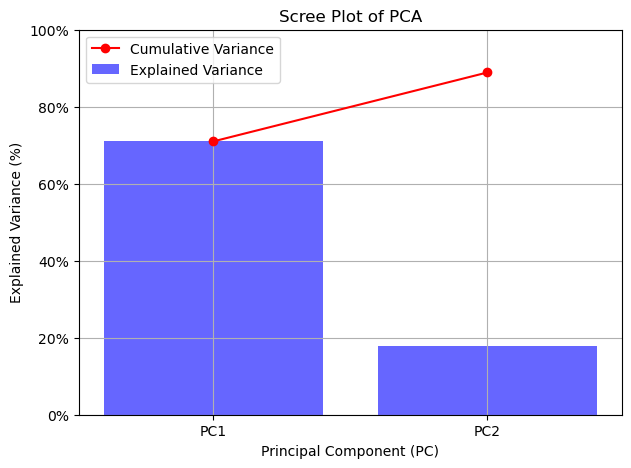

In [16]:


# Retrieve explained variance ratio from PCA
explained_variance_ratio = pca.explained_variance_ratio_

# Compute cumulative explained variance
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Create figure
plt.figure(figsize=(7,5))

# Bar plot for individual explained variance
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.6, color='b', label="Explained Variance")

# Line plot for cumulative variance
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-', color='r', label="Cumulative Variance")

# Labels and title
plt.xlabel("Principal Component (PC)")
plt.ylabel("Explained Variance (%)")
plt.title("Scree Plot of PCA")
plt.xticks(range(1, len(explained_variance_ratio) + 1), [f"PC{i}" for i in range(1, len(explained_variance_ratio) + 1)])
plt.yticks(np.arange(0, 1.1, 0.2), ["0%", "20%", "40%", "60%", "80%", "100%"])
plt.legend()
plt.grid()

# Show plot
plt.show()

## ÏúÑÏùòÍ≤É Í∑∏ÎûòÌîÑÌôî

In [17]:
# ‚úÖ 1. Í∞Å ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Í≥†Í∞ù Ïàò ÌôïÏù∏
cluster_counts = user_features.groupby("cluster").size()
print("Í∞Å ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Í≥†Í∞ù Ïàò:")
print(cluster_counts)

# ‚úÖ 2. Í∞Å ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÌèâÍ∑† Ï£ºÎ¨∏ ÌöüÏàò, Ïû¨Íµ¨Îß§Ïú® Î∂ÑÏÑù
cluster_means = user_features.groupby("cluster").mean()
print("\nÍ∞Å ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÌèâÍ∑† Í∞í (Ï£ºÎ¨∏ ÌöüÏàò, Ïû¨Íµ¨Îß§Ïú® Îì±):")
print(cluster_means)


Í∞Å ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Í≥†Í∞ù Ïàò:
cluster
0    64460
1    50671
2    25145
3    65933
dtype: int64

Í∞Å ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÌèâÍ∑† Í∞í (Ï£ºÎ¨∏ ÌöüÏàò, Ïû¨Íµ¨Îß§Ïú® Îì±):
               user_id  order_number  days_since_prior_order  reorder_rate
cluster                                                                   
0        102844.396742     18.951598               12.686930      0.576462
1        103216.648339      8.352174               12.773832      0.261549
2        102897.048638     52.516484                6.676457      0.729931
3        103353.283712      6.911911               23.549911      0.308918


### **üîç ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Î∂ÑÏÑù (Íµ¨Îß§ Ìå®ÌÑ¥ ÎπÑÍµê)**  

üìä **1. ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Í≥†Í∞ù Ïàò Î∂ÑÌè¨**  
- **Cluster 0** (üíú) ‚Üí **64,460Î™Ö (Í∞ÄÏû• ÎßéÏùÄ Í≥†Í∞ùÍµ∞)**  
- **Cluster 1** (üíô) ‚Üí **50,671Î™Ö**  
- **Cluster 2** (üíö) ‚Üí **25,145Î™Ö (Í∞ÄÏû• Ï†ÅÏùÄ Í≥†Í∞ùÍµ∞)**  
- **Cluster 3** (üíõ) ‚Üí **65,933Î™Ö**  

üí° **üëâ ÌÅ¥Îü¨Ïä§ÌÑ∞ 0Í≥º 3Ïù¥ Í∞ÄÏû• ÌÅ∞ Í∑∏Î£πÏù¥Î©∞, ÌÅ¥Îü¨Ïä§ÌÑ∞ 2Îäî Í∞ÄÏû• Ï†ÅÏùÄ Í≥†Í∞ùÏùÑ Ìè¨Ìï®Ìï®**  

---

üìä **2. ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÌèâÍ∑† Ï£ºÎ¨∏ Ìå®ÌÑ¥**  
| Cluster | ÌèâÍ∑† Ï£ºÎ¨∏ ÌöüÏàò (`order_number`) | ÌèâÍ∑† Ï£ºÎ¨∏ Í∞ÑÍ≤© (`days_since_prior_order`) | Ïû¨Íµ¨Îß§Ïú® (`reorder_rate`) |
|---------|----------------|----------------------|------------------|
| **0 (üíú)** | 18.95 Ìöå  | 12.69 Ïùº | **57.6%** |
| **1 (üíô)** | 8.35 Ìöå  | 12.77 Ïùº | **26.1%** |
| **2 (üíö)** | **52.51 Ìöå**  | **6.67 Ïùº** | **72.9%** |
| **3 (üíõ)** | **6.91 Ìöå**  | **23.55 Ïùº** | 30.8% |

üí° **üëâ Î∂ÑÏÑù Ìè¨Ïù∏Ìä∏:**  
1. **Cluster 2 (üíö) ‚Üí Í∞ÄÏû• ÎÜíÏùÄ Ïû¨Íµ¨Îß§Ïú® (72.9%) & Í∞ÄÏû• ÏûêÏ£º Ï£ºÎ¨∏ (6.67Ïùº Í∞ÑÍ≤©)**
   - ÏûêÏ£º Î∞òÎ≥µ Íµ¨Îß§ÌïòÎäî **Î°úÏó¥Ìã∞ ÎÜíÏùÄ Í≥†Í∞ù**  
   - **VIP Í≥†Í∞ùÍµ∞**, Ï†ïÍ∏∞Ï†ÅÏù∏ Íµ¨Îß§ Ìå®ÌÑ¥  

2. **Cluster 3 (üíõ) ‚Üí Í∞ÄÏû• ÎÇÆÏùÄ Ï£ºÎ¨∏ ÌöüÏàò (6.91Ìöå) & Í∞ÄÏû• Í∏¥ Ï£ºÎ¨∏ Í∞ÑÍ≤© (23.55Ïùº)**
   - **Ïã†Í∑ú Í≥†Í∞ù ÎòêÎäî Í∞ÄÎÅî Ï£ºÎ¨∏ÌïòÎäî Í≥†Í∞ù**  
   - Ïù¥ÌÉà Í∞ÄÎä•ÏÑ±Ïù¥ ÎÜíÏùÄ Í≥†Í∞ù ‚Üí **Ìï†Ïù∏ Ïø†Ìè∞, Ïû¨Íµ¨Îß§ Ïú†ÎèÑ ÎßàÏºÄÌåÖ ÌïÑÏöî**  

3. **Cluster 0 (üíú) ‚Üí ÌèâÍ∑†Ï†ÅÏù∏ Ï£ºÎ¨∏ Ìå®ÌÑ¥ (18.95Ìöå & 12.69Ïùº)**
   - ÏùºÎ∞òÏ†ÅÏù∏ Í≥†Í∞ù Ìå®ÌÑ¥ÏùÑ Î≥¥Ïù¥Î©∞, Ï†ÅÏ†àÌïú Ïû¨Íµ¨Îß§Ïú®(57.6%) Ïú†ÏßÄ  

4. **Cluster 1 (üíô) ‚Üí Ï£ºÎ¨∏ ÌöüÏàò Ï†ÅÍ≥†, Ïû¨Íµ¨Îß§Ïú®ÎèÑ ÎÇÆÏùå (26.1%)**
   - Í∞ÄÎÅî Ï£ºÎ¨∏ÌïòÎäî Í≥†Í∞ù, ÌäπÏ†ï ÏãúÏ¶åÏóêÎßå Íµ¨Îß§Ìï† Í∞ÄÎä•ÏÑ±  
   - **ÌôúÏÑ±ÌôîÎ•º ÏúÑÌïú ÎßûÏ∂§ ÎßàÏºÄÌåÖ ÌïÑÏöî**  

---

### **üìå Í≤∞Î°† Î∞è Ïù∏ÏÇ¨Ïù¥Ìä∏**
1Ô∏è‚É£ **Cluster 2 (üíö) VIP Í≥†Í∞ù**  
   - Ï£ºÎ¨∏ ÌöüÏàò ÎßéÍ≥†, Ïû¨Íµ¨Îß§Ïú®Ïù¥ ÎÜíÏùå ‚Üí **Íµ¨ÎèÖ ÏÑúÎπÑÏä§, Î©§Î≤ÑÏã≠ Ï†úÍ≥µ Í≥†Î†§**  

2Ô∏è‚É£ **Cluster 3 (üíõ) Ïã†Í∑ú ÎòêÎäî Ïù¥ÌÉà ÏúÑÌóò Í≥†Í∞ù**  
   - Ï£ºÎ¨∏ ÌöüÏàò Ï†ÅÍ≥†, Ï£ºÎ¨∏ Í∞ÑÍ≤© ÍπÄ ‚Üí **Ïø†Ìè∞ Ï†úÍ≥µ, Ïû¨Íµ¨Îß§ Ïú†ÎèÑ Ï∫†ÌéòÏù∏ ÌïÑÏöî**  

3Ô∏è‚É£ **Cluster 1 (üíô) ÎπÑÌôúÏÑ± Í≥†Í∞ù**  
   - Ïû¨Íµ¨Îß§Ïú® ÎÇÆÍ≥† Ï£ºÎ¨∏ ÌöüÏàò Ï†ÅÏùå ‚Üí **ÎßûÏ∂§Ìòï ÏÉÅÌíà Ï∂îÏ≤ú, Ïù¥Î©îÏùº ÎßàÏºÄÌåÖ ÌôúÏö©**  

4Ô∏è‚É£ **Cluster 0 (üíú) ÏùºÎ∞ò Í≥†Í∞ù**  
   - Íæ∏Ï§ÄÌïú Íµ¨Îß§Î•º Ïú†ÏßÄÌïòÎäî ÌïµÏã¨ Í≥†Í∞ùÍµ∞  

---

### **üí° Ï∂îÍ∞Ä Î∂ÑÏÑù Í∞ÄÎä• Ìè¨Ïù∏Ìä∏**
‚úÖ **ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Ï£ºÏöî Íµ¨Îß§ Ï†úÌíà Î∂ÑÏÑù (Ïñ¥Îñ§ Ï†úÌíàÏùÑ Ï£ºÎ°ú Íµ¨Îß§?)**  
‚úÖ **ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÏöîÏùºÎ≥Ñ/ÏãúÍ∞ÑÎåÄÎ≥Ñ Ï£ºÎ¨∏ Ìå®ÌÑ¥ Î∂ÑÏÑù**  
‚úÖ **ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Ïó∞Î†πÎåÄ, ÏßÄÏó≠ Îì± Ï∂îÍ∞ÄÏ†ÅÏù∏ Í≥†Í∞ù ÌäπÏÑ± Î∂ÑÏÑù Í∞ÄÎä•**  

üìä Ï∂îÍ∞Ä Î∂ÑÏÑùÏù¥ ÌïÑÏöîÌïòÎ©¥ ÏïåÎ†§Ï£ºÏÑ∏Ïöî! üòä

In [18]:
# ‚úÖ ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Ï£ºÏöî Íµ¨Îß§ Ï†úÌíà Î∂ÑÏÑù (Ïñ¥Îñ§ Ï†úÌíàÏùÑ Ï£ºÎ°ú Íµ¨Îß§?)
# df_priorÏôÄ df_productsÎ•º Í≤∞Ìï©ÌïòÏó¨ ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Ï†úÌíà Íµ¨Îß§ Î∂ÑÏÑù
df_prior_merge2 = df_prior_merge.merge(df_products[['product_id', 'product_name', 'department_id', 'aisle_id']], on='product_id', how='left')
df_prior_merge2 = df_prior_merge2.merge(user_features[['user_id', 'cluster']], on='user_id', how='left')

# ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥ÑÎ°ú Í∞ÄÏû• ÎßéÏù¥ Íµ¨Îß§Ìïú Ï†úÌíà ÏÉÅÏúÑ 10Í∞ú
cluster_top_products = df_prior_merge2.groupby(['cluster', 'product_name']).size().reset_index(name='count')
cluster_top_products = cluster_top_products.sort_values(['cluster', 'count'], ascending=[True, False])
print(cluster_top_products.groupby('cluster').head(10))

# ‚úÖ ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÏöîÏùºÎ≥Ñ/ÏãúÍ∞ÑÎåÄÎ≥Ñ Ï£ºÎ¨∏ Ìå®ÌÑ¥ Î∂ÑÏÑù # ÎçÆÏñ¥Ïì∞ÏßÄ ÏïäÍ≥† ÏÉàÎ°ú dddf_ordersÎ°ú ÏÉùÏÑ±
dddf_orders = df_orders.merge(user_features[['user_id', 'cluster']], on='user_id', how='left')

# ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÏöîÏùºÎ≥Ñ ÌèâÍ∑† Ï£ºÎ¨∏ Ïàò Í≥ÑÏÇ∞
cluster_order_dow = dddf_orders.groupby(['cluster', 'order_dow']).size().reset_index(name='count')
print(cluster_order_dow)

# ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÏãúÍ∞ÑÎåÄÎ≥Ñ ÌèâÍ∑† Ï£ºÎ¨∏ Ïàò Í≥ÑÏÇ∞
cluster_order_hour = dddf_orders.groupby(['cluster', 'order_hour_of_day']).size().reset_index(name='count')
print(cluster_order_hour)


        cluster            product_name   count
3561          0                  Banana  177276
3362          0  Bag of Organic Bananas  132622
27992         0    Organic Baby Spinach   91111
31025         0    Organic Strawberries   90490
29435         0    Organic Hass Avocado   74392
27956         0         Organic Avocado   69573
21752         0             Large Lemon   58780
41700         0            Strawberries   54031
22736         0                   Limes   52762
31571         0      Organic Whole Milk   46713
51702         1                  Banana   39455
51509         1  Bag of Organic Bananas   25744
75291         1    Organic Baby Spinach   19145
78235         1    Organic Strawberries   17648
75257         1         Organic Avocado   17094
69255         1             Large Lemon   16854
70196         1                   Limes   14359
76683         1    Organic Hass Avocado   14184
88597         1            Strawberries   13738
94602         1           Yellow Onions 

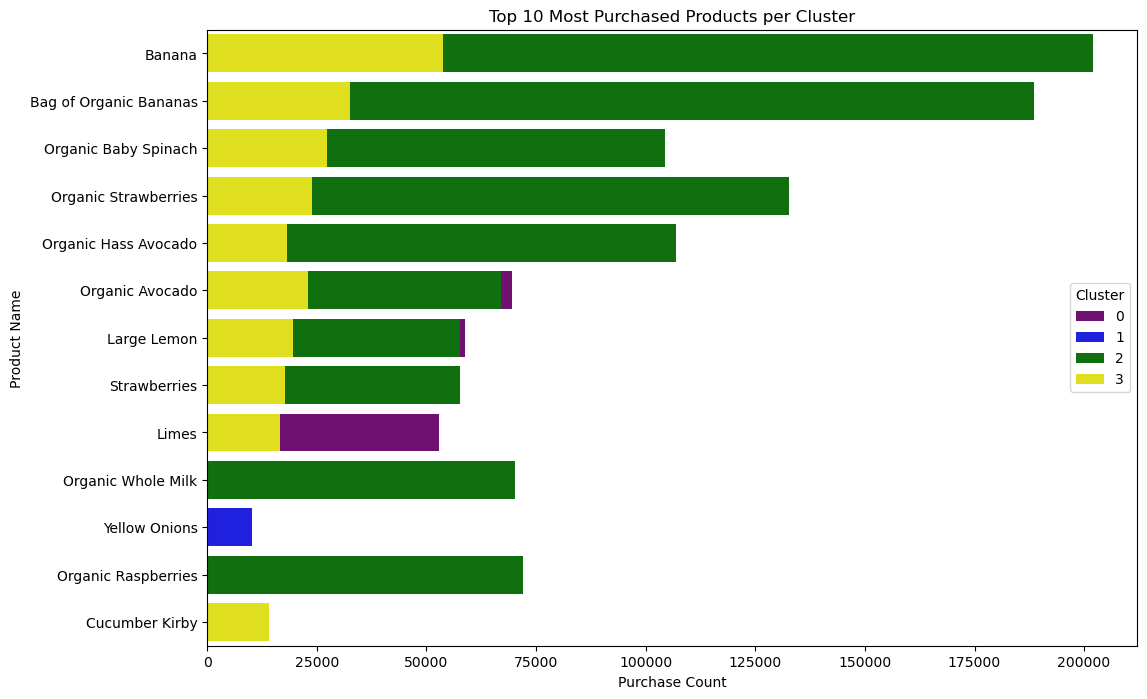

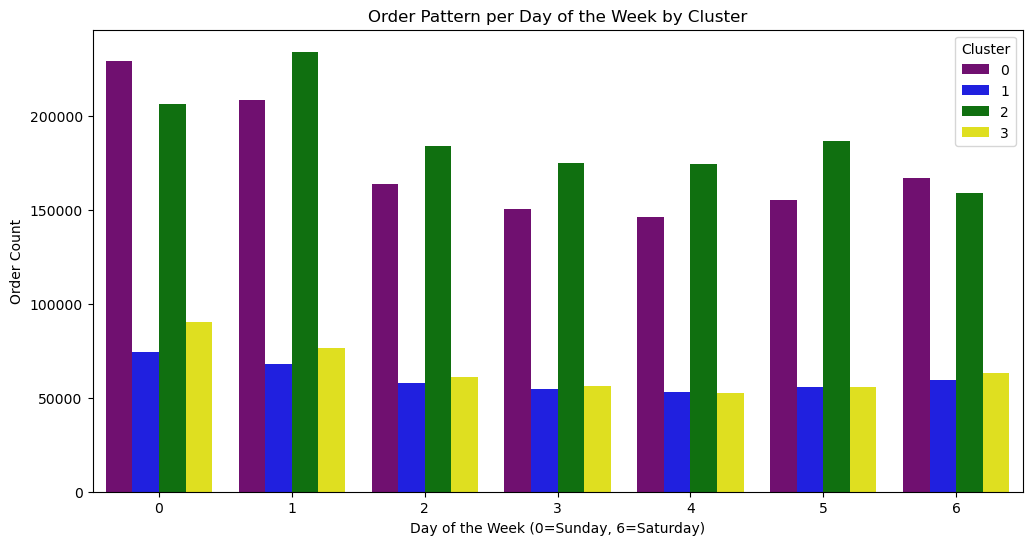

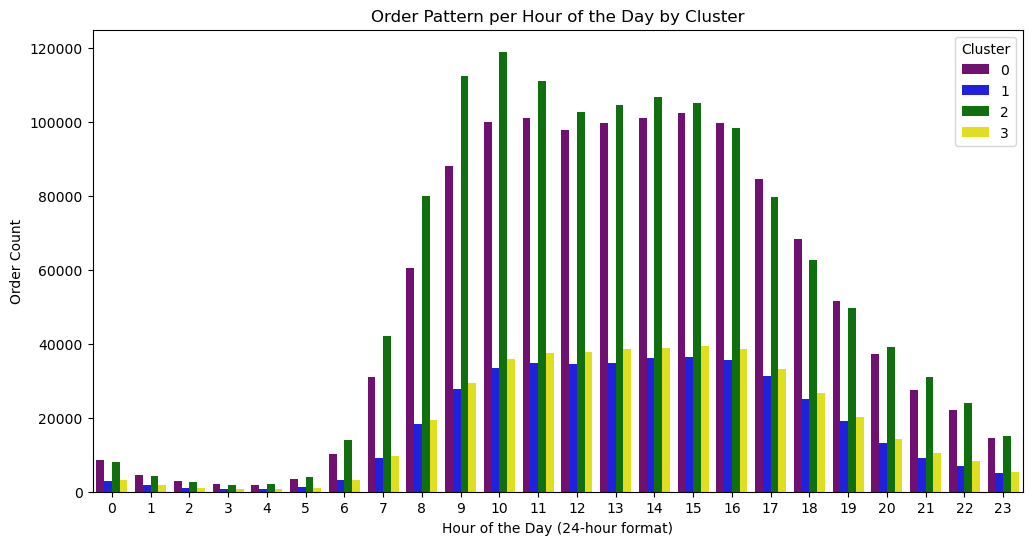

In [19]:
cluster_colors = {0: 'purple', 1: 'blue', 2: 'green', 3: 'yellow'}


# ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Í∞ÄÏû• ÎßéÏù¥ Íµ¨Îß§Ìïú Ï†úÌíà ÏÉÅÏúÑ 10Í∞ú ÏãúÍ∞ÅÌôî
top_products = cluster_top_products.groupby('cluster').head(10)
plt.figure(figsize=(12, 8))
sns.barplot(data=top_products, x='count', y='product_name', hue='cluster', dodge=False, palette=cluster_colors)
plt.xlabel("Purchase Count")
plt.ylabel("Product Name")
plt.title("Top 10 Most Purchased Products per Cluster")
plt.legend(title="Cluster")
plt.show()

# ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÏöîÏùºÎ≥Ñ Ï£ºÎ¨∏ Ìå®ÌÑ¥ ÏãúÍ∞ÅÌôî
plt.figure(figsize=(12, 6))
sns.barplot(data=cluster_order_dow, x='order_dow', y='count', hue='cluster', palette=cluster_colors)
plt.xlabel("Day of the Week (0=Sunday, 6=Saturday)")
plt.ylabel("Order Count")
plt.title("Order Pattern per Day of the Week by Cluster")
plt.legend(title="Cluster")
plt.show()

# ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÏãúÍ∞ÑÎåÄÎ≥Ñ Ï£ºÎ¨∏ Ìå®ÌÑ¥ ÏãúÍ∞ÅÌôî
plt.figure(figsize=(12, 6))
sns.barplot(data=cluster_order_hour, x='order_hour_of_day', y='count', hue='cluster', palette=cluster_colors)
plt.xlabel("Hour of the Day (24-hour format)")
plt.ylabel("Order Count")
plt.title("Order Pattern per Hour of the Day by Cluster")
plt.legend(title="Cluster")
plt.show()

### **üîç ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Ï£ºÏöî Î∂ÑÏÑù (Ï†úÌíà Íµ¨Îß§ & Ï£ºÎ¨∏ Ìå®ÌÑ¥ ÎπÑÍµê)**  

#### **üìå 1. ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥ÑÎ°ú ÎßéÏù¥ Íµ¨Îß§Ìïú Ï†úÌíà TOP 10**  
‚úÖ **Î™®Îì† ÌÅ¥Îü¨Ïä§ÌÑ∞ÏóêÏÑú Í∞ÄÏû• ÎßéÏù¥ Íµ¨Îß§ÌïòÎäî Ï†úÌíàÏùÄ Ïã†ÏÑ†ÏãùÌíà(Í≥ºÏùº, Ï±ÑÏÜå, Ïú†Ï†úÌíà)Ïù¥Îã§.**  
‚úÖ **ÌÅ¥Îü¨Ïä§ÌÑ∞ 2Í∞Ä Í∞ÄÏû• ÎßéÏùÄ ÏàòÎüâÏùÑ Íµ¨Îß§ÌïòÎ©∞, Ï†ÑÏ≤¥Ï†ÅÏúºÎ°ú Ïú†Í∏∞ÎÜç Ï†úÌíà ÏÑ†Ìò∏ÎèÑÍ∞Ä ÎÜíÎã§.**  

| Cluster | Ï†úÌíà | Íµ¨Îß§Îüâ |
|---------|-------------|----------|
| **0 (üíú)** | Banana | **177,276** |
| **1 (üíô)** | Banana | **39,455** |
| **2 (üíö)** | Banana | **202,023** |
| **3 (üíõ)** | Banana | **53,811** |

**üí° Ìï¥ÏÑù:**  
- **Î™®Îì† ÌÅ¥Îü¨Ïä§ÌÑ∞ÏóêÏÑú "Banana(Î∞îÎÇòÎÇò)"Í∞Ä 1ÏúÑÎ°ú Í∞ÄÏû• ÎßéÏù¥ Íµ¨Îß§Îê®.**  
- **Ïú†Í∏∞ÎÜç Ï†úÌíà(Organic Baby Spinach, Organic Hass Avocado, Organic Strawberries Îì±)Ïùò Ïù∏Í∏∞Í∞Ä ÎÜíÏùå.**  
- **Cluster 2(üíö)Îäî Ïú†Í∏∞ÎÜç Ï†úÌíàÏùÑ Í∞ÄÏû• ÎßéÏù¥ Íµ¨Îß§ÌïòÎ©∞, Ï∂©ÏÑ± Í≥†Í∞ùÏ∏µÏù¥ ÎßéÏùÑ Í∞ÄÎä•ÏÑ±Ïù¥ ÌÅº.**  
- **Cluster 3(üíõ)Îäî Ïò§Ïù¥(Cucumber Kirby)Î•º ÏÉÅÏúÑ 10ÏúÑ ÎÇ¥Ïóê Ìè¨Ìï®Ìïú Ïú†ÏùºÌïú Í∑∏Î£π ‚Üí ÌäπÏ†ïÌïú ÏÜåÎπÑ Ìå®ÌÑ¥ÏùÑ Î≥¥Ïùº Í∞ÄÎä•ÏÑ± ÏûàÏùå.**  

---

#### **üìå 2. ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÏöîÏùºÎ≥Ñ Ï£ºÎ¨∏ Ìå®ÌÑ¥**
‚úÖ **ÌÅ¥Îü¨Ïä§ÌÑ∞ 0(üíú) & ÌÅ¥Îü¨Ïä§ÌÑ∞ 2(üíö)Îäî Ï£ºÎßê(ÌÜ†, Ïùº)Ïóê Ï£ºÎ¨∏Ïù¥ ÏßëÏ§ëÎê®.**  
‚úÖ **ÌÅ¥Îü¨Ïä§ÌÑ∞ 1(üíô) & ÌÅ¥Îü¨Ïä§ÌÑ∞ 3(üíõ)Îäî ÌèâÏùº(Ïõî~Í∏à)Ïóê Îçî ÎßéÏù¥ Ï£ºÎ¨∏ÌïòÎäî Í≤ΩÌñ•Ïù¥ ÏûàÏùå.**  

**üí° Ìï¥ÏÑù:**  
- **Cluster 2(üíö)Îäî ÏùºÏöîÏùº(234,370Í±¥) Ï£ºÎ¨∏Ïù¥ Í∞ÄÏû• ÎßéÏúºÎ©∞, Ï£ºÎßêÏóê ÏßëÏ§ëÏ†ÅÏúºÎ°ú Ï£ºÎ¨∏ÌïòÎäî Í≤ΩÌñ•Ïù¥ ÏûàÏùå.**  
- **Cluster 0(üíú) Ïó≠Ïãú Ï£ºÎßêÏóê Ï£ºÎ¨∏ÎüâÏù¥ ÎßéÏúºÎ©∞, Ï†ÑÏ≤¥Ï†ÅÏúºÎ°ú Ï£ºÎ¨∏ÎüâÏù¥ ÎÜíÏùÄ Í∑∏Î£πÏù¥Îã§.**  
- **Cluster 1(üíô)Í≥º Cluster 3(üíõ)Îäî Ïõî~Í∏à(ÌèâÏùº)Ïóê Ï£ºÎ¨∏Ïù¥ ÎßéÏù¥ Ïù¥Î£®Ïñ¥ÏßÄÎ©∞, ÏóÖÎ¨¥ Ìå®ÌÑ¥Í≥º Í¥ÄÎ†® ÏûàÏùÑ Í∞ÄÎä•ÏÑ±Ïù¥ ÏûàÏùå.**  
- **Ï¶â, Cluster 2(üíö)ÏôÄ Cluster 0(üíú)Îäî Ï£ºÎßê ÎßûÏ∂§Ìòï Ìï†Ïù∏/ÌîÑÎ°úÎ™®ÏÖòÏù¥ Ìö®Í≥ºÏ†ÅÏù¥Í≥†, Cluster 1(üíô)Í≥º Cluster 3(üíõ)Îäî ÌèâÏùº ÎßûÏ∂§Ìòï Ï∫†ÌéòÏù∏Ïù¥ Ïú†Ìö®Ìï† Ïàò ÏûàÏùå.**  

---

#### **üìå 3. ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÏãúÍ∞ÑÎåÄÎ≥Ñ Ï£ºÎ¨∏ Ìå®ÌÑ¥**  
‚úÖ **Î™®Îì† ÌÅ¥Îü¨Ïä§ÌÑ∞ÏóêÏÑú Ïò§Ï†Ñ 10~11Ïãú Ï£ºÎ¨∏ÎüâÏù¥ Í∞ÄÏû• ÎßéÏùå.**  
‚úÖ **ÌÅ¥Îü¨Ïä§ÌÑ∞ 2(üíö)Îäî Î∞§ Îä¶Í≤åÍπåÏßÄ Ï£ºÎ¨∏ÌïòÎäî Í≤ΩÌñ•Ïù¥ ÏûàÏùå.**  

**üí° Ìï¥ÏÑù:**  
- **Î™®Îì† ÌÅ¥Îü¨Ïä§ÌÑ∞ÏóêÏÑú ÏÉàÎ≤Ω 3~6Ïãú Ï£ºÎ¨∏ÎüâÏù¥ Í∞ÄÏû• Ï†ÅÍ≥†, Ïò§Ï†Ñ 10~11ÏãúÏóê Ï£ºÎ¨∏ÎüâÏù¥ Í∏âÏ¶ùÌï®.**  
- **Cluster 2(üíö)Îäî Î∞§ 21~23ÏãúÏóêÎèÑ ÏÉÅÎåÄÏ†ÅÏúºÎ°ú ÎÜíÏùÄ Ï£ºÎ¨∏ÎüâÏùÑ Î≥¥Ïù¥Î©∞, Îä¶ÏùÄ ÏãúÍ∞Ñ ÏáºÌïëÏùÑ ÏÑ†Ìò∏ÌïòÎäî Í≥†Í∞ùÏ∏µÏù¥ Ìè¨Ìï®Îê† Í∞ÄÎä•ÏÑ±Ïù¥ ÏûàÏùå.**  
- **Cluster 3(üíõ)Îäî Ï†ÄÎÖÅ 19~21ÏãúÏóê Ï£ºÎ¨∏ÎüâÏù¥ ÎßéÏïÑ, ÏßÅÏû•Ïù∏ Í≥†Í∞ùÏù¥ Ìè¨Ìï®Îê† Í∞ÄÎä•ÏÑ±Ïù¥ ÎÜíÏùå.**  
- **Ïù¥ Ï†ïÎ≥¥Î•º Í∏∞Î∞òÏúºÎ°ú ÌäπÏ†ï ÏãúÍ∞ÑÎåÄ ÎßûÏ∂§Ìòï ÌîÑÎ°úÎ™®ÏÖò(Ïòà: "ÏïºÍ∞Ñ Ìï†Ïù∏" ÎòêÎäî "Ï∂úÍ∑º Ï†Ñ Ï£ºÎ¨∏ ÌòúÌÉù")ÏùÑ Í≥†Î†§Ìï† Ïàò ÏûàÏùå.**  

---

### **üìä ÏµúÏ¢Ö Í≤∞Î°† Î∞è Ïù∏ÏÇ¨Ïù¥Ìä∏**  
1Ô∏è‚É£ **Î™®Îì† ÌÅ¥Îü¨Ïä§ÌÑ∞ÏóêÏÑú Ïã†ÏÑ†ÏãùÌíà(ÌäπÌûà Î∞îÎÇòÎÇò)Ïù¥ Í∞ÄÏû• Ïù∏Í∏∞ ÎßéÏùå.**  
2Ô∏è‚É£ **Cluster 2(üíö)ÏôÄ Cluster 0(üíú)Îäî Ï£ºÎßê ÏáºÌïëÏùÑ ÏÑ†Ìò∏ÌïòÎØÄÎ°ú, Ï£ºÎßê ÎßûÏ∂§Ìòï Ìï†Ïù∏ Ïù¥Î≤§Ìä∏Í∞Ä Ìö®Í≥ºÏ†Å.**  
3Ô∏è‚É£ **Cluster 1(üíô)Í≥º Cluster 3(üíõ)Îäî ÌèâÏùºÏóê Îçî ÎßéÏù¥ Ï£ºÎ¨∏ÌïòÎØÄÎ°ú, Ï∂úÍ∑º Ï†Ñ & Ï†êÏã¨ÏãúÍ∞Ñ ÌÉÄÍ≤üÌåÖ ÎßàÏºÄÌåÖÏù¥ Ïú†Ìö®Ìï®.**  
4Ô∏è‚É£ **Cluster 2(üíö)Îäî Îä¶ÏùÄ Î∞§ÏóêÎèÑ Ï£ºÎ¨∏ÏùÑ ÎßéÏù¥ ÌïòÎäî Í≤ΩÌñ•Ïù¥ ÏûàÏñ¥, ÏïºÍ∞Ñ Ìï†Ïù∏ÏùÑ ÌôúÏö©ÌïòÎ©¥ Ï∂îÍ∞Ä Îß§Ï∂ú Í∞ÄÎä•ÏÑ±Ïù¥ ÏûàÏùå.**  

üìä **Ï∂îÍ∞Ä Î∂ÑÏÑùÏù¥ ÌïÑÏöîÌïòÎ©¥ ÏïåÎ†§Ï£ºÏÑ∏Ïöî! üòä**

In [20]:
# ‚úÖ ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Ï£ºÏöî Íµ¨Îß§ Ï†úÌíà Î∂ÑÏÑù (Ïñ¥Îñ§ Ï†úÌíàÏùÑ Ï£ºÎ°ú Íµ¨Îß§?)
# df_priorÏôÄ df_productsÎ•º Í≤∞Ìï©ÌïòÏó¨ ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Ï†úÌíà Íµ¨Îß§ Î∂ÑÏÑù
df_prior_merge3 = df_prior_merge.merge(df_products[['product_id', 'product_name', 'department_id', 'aisle_id','aisle']], on='product_id', how='left')
df_prior_merge3 = df_prior_merge3.merge(user_features[['user_id', 'cluster']], on='user_id', how='left')

# ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥ÑÎ°ú Í∞ÄÏû• ÎßéÏù¥ Íµ¨Îß§Ìïú Îã®ÏúÑÏ†úÌíà? ÏÉÅÏúÑ 10Í∞ú
cluster_top_products = df_prior_merge3.groupby(['cluster', 'aisle_id','aisle']).size().reset_index(name='count')
cluster_top_products = cluster_top_products.sort_values(['cluster', 'count'], ascending=[True, False])
print(cluster_top_products.groupby('cluster').head(10))

# ‚úÖ ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÏöîÏùºÎ≥Ñ/ÏãúÍ∞ÑÎåÄÎ≥Ñ Ï£ºÎ¨∏ Ìå®ÌÑ¥ Î∂ÑÏÑù
dddf_orders = df_orders.merge(user_features[['user_id', 'cluster']], on='user_id', how='left')

# ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÏöîÏùºÎ≥Ñ ÌèâÍ∑† Ï£ºÎ¨∏ Ïàò Í≥ÑÏÇ∞
cluster_order_dow = dddf_orders.groupby(['cluster', 'order_dow']).size().reset_index(name='count')
print(cluster_order_dow)

# ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÏãúÍ∞ÑÎåÄÎ≥Ñ ÌèâÍ∑† Ï£ºÎ¨∏ Ïàò Í≥ÑÏÇ∞
cluster_order_hour = dddf_orders.groupby(['cluster', 'order_hour_of_day']).size().reset_index(name='count')
print(cluster_order_hour)

# ÏïÑÎûò ÏûàÎäî Í≤∞Í≥º Î¨¥ÏãúÌïòÏãúÍ≥† Îã§Ïãú ÏúÑÏóêÏÑúÎ∂ÄÌÑ∞ Ïû¨ÏÉùÌïòÏÑ∏Ïöî. Ïù¥Í±∞ Îã§Î•∏Í±∞ Íµ¨Î∂ÑÌïúÍ±∞ Í∞ôÏùå.
#aisle_id Î∂ÑÏÑù Í≤∞Í≥º daily ÏãùÌíàÏùÑ ÏûêÏ£º Íµ¨Îß§ÌïòÎ©∞ banana ÎßéÏù¥ Íµ¨Îß§ÌïúÎã§Îäî Í≤∞Í≥ºÎùºÎäî Îã§Î•∏ Î™®Ïäµ Î≥¥ÏùºÍ±∞ÏóêÏöî.

     cluster  aisle_id                          aisle    count
23         0        24                   fresh fruits  1305872
82         0        83               fresh vegetables  1274683
122        0       123     packaged vegetables fruits   654909
119        0       120                         yogurt   517667
20         0        21                packaged cheese   361984
114        0       115  water seltzer sparkling water   312949
83         0        84                           milk   307711
106        0       107                 chips pretzels   270399
90         0        91                soy lactosefree   232444
111        0       112                          bread   213597
216        1        83               fresh vegetables   355821
157        1        24                   fresh fruits   303135
256        1       123     packaged vegetables fruits   167906
253        1       120                         yogurt   119283
154        1        21                packaged cheese  

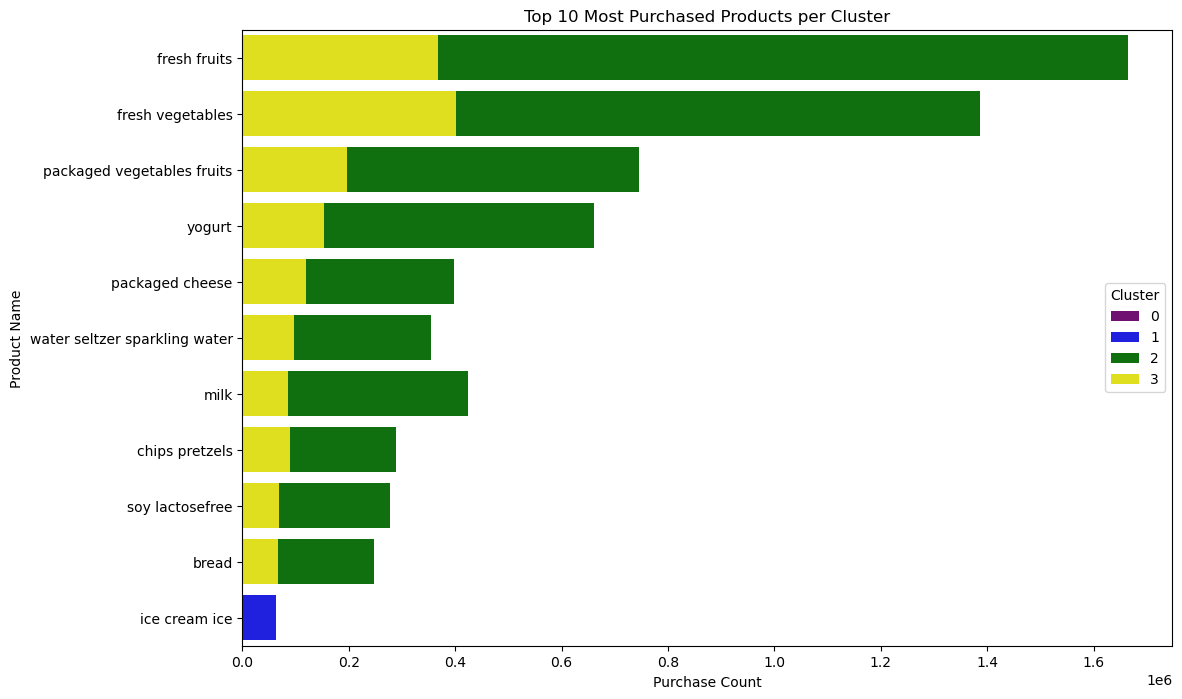

In [21]:
cluster_colors = {0: 'purple', 1: 'blue', 2: 'green', 3: 'yellow'}


# ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Í∞ÄÏû• ÎßéÏù¥ Íµ¨Îß§Ìïú aisle Í∏∞Ï§Ä Ï†úÌíà ÏÉÅÏúÑ 10Í∞ú ÏãúÍ∞ÅÌôî
top_products = cluster_top_products.groupby('cluster').head(10)
plt.figure(figsize=(12, 8))
sns.barplot(data=top_products, x='count', y='aisle', hue='cluster', dodge=False, palette=cluster_colors)
plt.xlabel("Purchase Count")
plt.ylabel("Product Name")
plt.title("Top 10 Most Purchased Products per Cluster")
plt.legend(title="Cluster")
plt.show()



Í∑∏ÎûòÌîÑÎ•º Í∏∞Î∞òÏúºÎ°ú Ìïú Ï£ºÏöî Ïù∏ÏÇ¨Ïù¥Ìä∏ 3Í∞ÄÏßÄÎ•º Ï†ïÎ¶¨Ìï¥ ÎìúÎ¶¥Í≤åÏöî.

### 1. **Cluster 2 (Ï≤≠Î°ùÏÉâ)Í∞Ä ÎåÄÎ∂ÄÎ∂ÑÏùò Ï£ºÏöî Ï†úÌíà Íµ¨Îß§Î•º Ï£ºÎèÑ**
   - `Fresh Fruits`, `Fresh Vegetables`, `Packaged Vegetables Fruits` Îì± Í∞ÄÏû• ÎßéÏù¥ Íµ¨Îß§Îêú Ï†úÌíàÎì§Ïù¥ ÎåÄÎ∂ÄÎ∂Ñ **Cluster 2 (Ï≤≠Î°ùÏÉâ)**Ïóê ÏÜçÌï¥ ÏûàÏùå.
   - Ïù¥Îäî **VIP Í≥†Í∞ùÏ∏µ(Ïû¨Íµ¨Îß§Ïú®Í≥º Ï£ºÎ¨∏ ÌöüÏàòÍ∞Ä ÎÜíÏùÄ Í∑∏Î£π)**Ïù¥ Ïã†ÏÑ†ÏãùÌíàÏùÑ ÏÑ†Ìò∏ÌïòÎäî Í≤ΩÌñ•Ïù¥ ÏûàÏùåÏùÑ ÏãúÏÇ¨Ìï®.
   - Ìï¥Îãπ Í≥†Í∞ùÏ∏µÏùÑ ÌÉÄÍ≤üÏúºÎ°ú ÌïòÎäî **ÌîÑÎ¶¨ÎØ∏ÏóÑ Ïã†ÏÑ†ÏãùÌíà ÎßàÏºÄÌåÖ Ï†ÑÎûµ**Ïù¥ Ìö®Í≥ºÏ†ÅÏùº Í∞ÄÎä•ÏÑ±Ïù¥ ÏûàÏùå.

### 2. **Cluster 3 (ÎÖ∏ÎûÄÏÉâ)Îäî ÏùºÎ∂Ä Ïã†ÏÑ†ÏãùÌíàÍ≥º Í∞ÑÏãùÎ•òÏóêÏÑú ÏòÅÌñ•Î†• ÏûàÏùå**
   - `Fresh Fruits`, `Fresh Vegetables`, `Packaged Vegetables Fruits`, `Yogurt`, `Chips Pretzels` Îì±Ïùò Ï†úÌíàÏóêÏÑú **Cluster 3 (ÎÖ∏ÎûÄÏÉâ) Í≥†Í∞ùÏùò Íµ¨Îß§ÎüâÎèÑ ÏÉÅÎãπÌï®**.
   - Í∑∏Îü¨ÎÇò **Ïû¨Íµ¨Îß§Ïú®Ïù¥ ÎÇÆÏùÄ Í∑∏Î£π**Ïù¥ÎØÄÎ°ú, Ïù¥Îì§ÏùÑ Ï∂©ÏÑ± Í≥†Í∞ùÏúºÎ°ú Ï†ÑÌôòÌï† Ï†ÑÎûµ(Ïòà: Ìï†Ïù∏ Ïø†Ìè∞, Ï†ïÍ∏∞Î∞∞ÏÜ° ÏÑúÎπÑÏä§ Îì±)Ïù¥ ÌïÑÏöîÌï®.

### 3. **Cluster 1 (ÌååÎûÄÏÉâ)ÏùÄ ÌäπÏ†ï Ï†úÌíàÍµ∞ÏóêÏÑúÎßå ÎëêÎìúÎü¨Ïßê (ÎãàÏπò Í≥†Í∞ùÏ∏µ)**
   - `Ice Cream Ice` Ï†úÌíàÏóêÏÑúÎßå **Cluster 1 (ÌååÎûÄÏÉâ) Í≥†Í∞ùÏù¥ ÎÜíÏùÄ Íµ¨Îß§ ÎπÑÏ§ë**ÏùÑ Ï∞®ÏßÄÌïòÍ≥† ÏûàÏùå.
   - Ïù¥Îäî **Ìï¥Îãπ Ï†úÌíàÏù¥ ÌäπÏ†ï ÏãúÍ∞ÑÎåÄ/ÏãúÏ¶åÏóê ÏßëÏ§ëÏ†ÅÏúºÎ°ú Íµ¨Îß§ÎêòÎäî Í≤ΩÌñ•**ÏùÑ ÎÇòÌÉÄÎÇº Ïàò ÏûàÏùå.
   - ÌäπÏ†ï ÌîÑÎ°úÎ™®ÏÖò(Ïòà: Ïó¨Î¶ÑÏ≤† Ìï†Ïù∏, ÌäπÏ†ï ÏãúÍ∞ÑÎåÄ ÏïÑÏù¥Ïä§ÌÅ¨Î¶º Íµ¨Îß§ Ïãú ÌòúÌÉù Ï†úÍ≥µ) Ï†ÑÎûµÏù¥ Ïú†Ìö®Ìï† Ïàò ÏûàÏùå.

Ïù¥ Îç∞Ïù¥ÌÑ∞Î•º Í∏∞Î∞òÏúºÎ°ú **Í∞Å ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÎßûÏ∂§ ÎßàÏºÄÌåÖ Ï†ÑÎûµ**ÏùÑ ÏàòÎ¶ΩÌïòÎ©¥ Ìö®Í≥ºÏ†ÅÏù∏ Í≥†Í∞ù Ïú†ÏßÄ Î∞è Îß§Ï∂ú Ìñ•ÏÉÅÏù¥ Í∞ÄÎä•Ìï† Í≤ÉÏúºÎ°ú Î≥¥ÏûÖÎãàÎã§! üöÄ

### Ïã†Í∑úÍ≥†Í∞ùÎßå Î∂ÑÏÑù

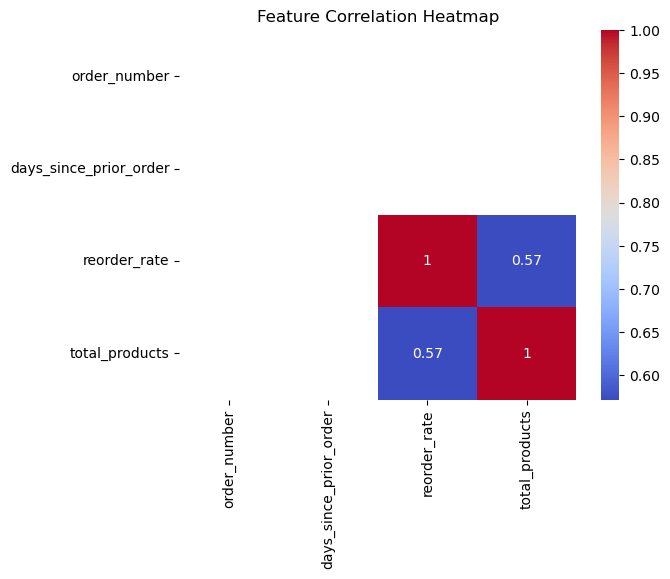

Explained Variance Ratio: [7.85828258e-01 2.14171742e-01 5.33853417e-62]


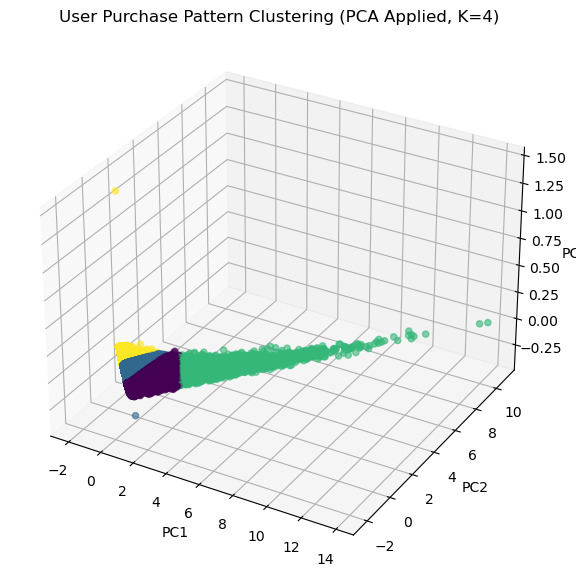

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# ‚úÖ NaN Í∞íÏù¥ ÏûàÎäî ÌñâÎßå ÏÑ†ÌÉù (999Î°ú Î≥ÄÌôòÎêú Í∞í)
df_orders_nan = df_orders[df_orders["days_since_prior_order"] == 999]

# ‚úÖ ÏÇ¨Ïö©ÏûêÎ≥Ñ Ï£ºÎ¨∏ ÌÜµÍ≥Ñ Í≥ÑÏÇ∞
user_order_stats = df_orders_nan.groupby("user_id").agg({
    "order_number": "max",  # Ï¥ù Ï£ºÎ¨∏ ÌöüÏàò
    "days_since_prior_order": "mean"  # ÌèâÍ∑† Ï£ºÎ¨∏ Í∞ÑÍ≤©
})

# ‚úÖ df_priorÏóê user_id Ï∂îÍ∞Ä (df_ordersÏôÄ Î≥ëÌï©)
df_prior_merge = df_prior.merge(df_orders[['order_id', 'user_id']], on='order_id', how='left')

# ‚úÖ ÏÇ¨Ïö©ÏûêÎ≥Ñ Ïû¨Íµ¨Îß§Ïú® Í≥ÑÏÇ∞ (user_id Í∏∞Ï§Ä)
user_reorder_stats = df_prior_merge.groupby("user_id")["reordered"].mean().reset_index()
user_reorder_stats = user_reorder_stats.rename(columns={"reordered": "reorder_rate"})

# ‚úÖ Ï∂îÍ∞Ä feature ÏÉùÏÑ± (ÏÇ¨Ïö©ÏûêÎ≥Ñ Ï¥ù Ï£ºÎ¨∏ ÏÉÅÌíà Í∞úÏàò Ï∂îÍ∞Ä)
user_total_products = df_prior_merge.groupby("user_id").size().reset_index(name="total_products")

# ‚úÖ Îç∞Ïù¥ÌÑ∞ Î≥ëÌï© (user_id Í∏∞Ï§Ä)
user_features = user_order_stats.merge(user_reorder_stats, on="user_id", how="left").fillna(0)
user_features = user_features.merge(user_total_products, on="user_id", how="left").fillna(0)

# ‚úÖ Îç∞Ïù¥ÌÑ∞ ÌëúÏ§ÄÌôî
scaler = StandardScaler()
user_features_scaled = scaler.fit_transform(user_features.iloc[:, 1:])  # user_id Ï†úÏô∏

# ‚úÖ feature Í∞ÑÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÌôïÏù∏
sns.heatmap(pd.DataFrame(user_features_scaled, columns=user_features.columns[1:]).corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# ‚úÖ PCA Ï†ÅÏö© (Ï∞®Ïõê Ï∂ïÏÜå)
pca = PCA(n_components=3)
user_pca = pca.fit_transform(user_features_scaled)

# ‚úÖ Ï£ºÏÑ±Î∂Ñ ÏÑ§Î™ÖÎ†• ÌôïÏù∏
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# ‚úÖ K-Means ÌÅ¥Îü¨Ïä§ÌÑ∞ Í∞úÏàò ÏµúÏ†ÅÌôî: n_clusters=3,4,5 ÎπÑÍµê
optimal_k = [3, 4, 5]
cluster_results = {}

for k in optimal_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(user_pca)
    cluster_results[k] = clusters

# ‚úÖ ÏµúÏ†Å ÌÅ¥Îü¨Ïä§ÌÑ∞ Í∞úÏàò ÏÑ†ÌÉù (Í∏∞Î≥∏Ï†ÅÏúºÎ°ú n=4 ÏÇ¨Ïö©)
selected_k = 4
user_clusters = cluster_results[selected_k]

# ‚úÖ ÌÅ¥Îü¨Ïä§ÌÑ∞ Í≤∞Í≥º Ï†ÄÏû•
user_features["cluster"] = user_clusters

# ‚úÖ 3D ÏãúÍ∞ÅÌôî (PCA Ï†ÅÏö© ÌõÑ)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(user_pca[:, 0], user_pca[:, 1], user_pca[:, 2], c=user_clusters, cmap='viridis', alpha=0.6)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title(f"User Purchase Pattern Clustering (PCA Applied, K={selected_k})")
plt.show()


 Ïûò ÎÇòÎâòÏñ¥ÏßÄÏßÄ ÏïäÏùå. ÌïúÏ™Ω Î∞©Ìñ•ÏúºÎ°ú Í∑∏Î£πÌôîÍ∞Ä ÏπòÏö∞Ï≥êÏûàÏùå

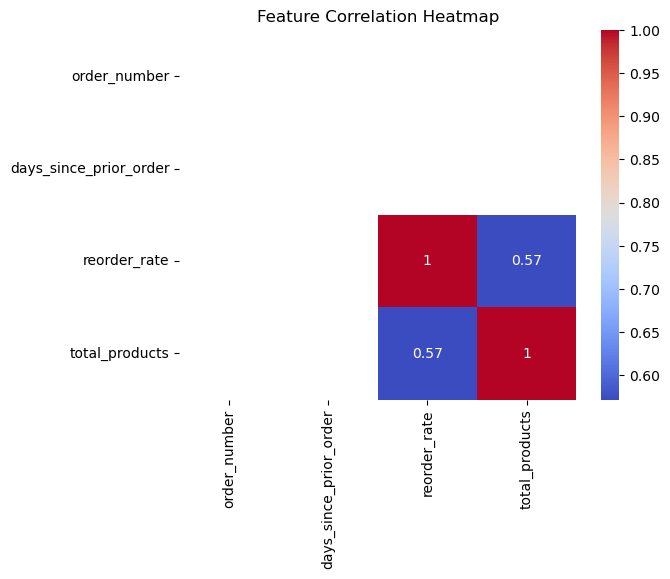

Explained Variance Ratio: [7.85828258e-01 2.14171742e-01 4.63316398e-66]


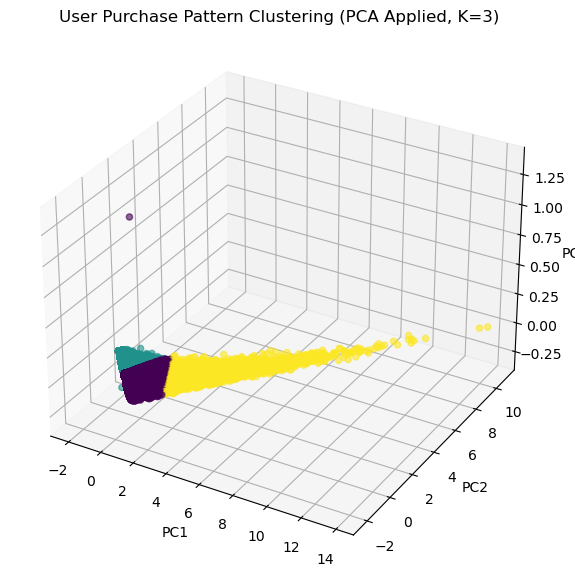

In [23]:



# ‚úÖ NaN Í∞íÏù¥ ÏûàÎäî ÌñâÎßå ÏÑ†ÌÉù (999Î°ú Î≥ÄÌôòÎêú Í∞í)
df_orders_nan = df_orders[df_orders["days_since_prior_order"] == 999]

# ‚úÖ ÏÇ¨Ïö©ÏûêÎ≥Ñ Ï£ºÎ¨∏ ÌÜµÍ≥Ñ Í≥ÑÏÇ∞
user_order_stats = df_orders_nan.groupby("user_id").agg({
    "order_number": "max",  # Ï¥ù Ï£ºÎ¨∏ ÌöüÏàò
    "days_since_prior_order": "mean"  # ÌèâÍ∑† Ï£ºÎ¨∏ Í∞ÑÍ≤©
})

# ‚úÖ df_priorÏóê user_id Ï∂îÍ∞Ä (df_ordersÏôÄ Î≥ëÌï©)
df_prior_merge = df_prior.merge(df_orders[['order_id', 'user_id']], on='order_id', how='left')

# ‚úÖ ÏÇ¨Ïö©ÏûêÎ≥Ñ Ïû¨Íµ¨Îß§Ïú® Í≥ÑÏÇ∞ (user_id Í∏∞Ï§Ä)
user_reorder_stats = df_prior_merge.groupby("user_id")["reordered"].mean().reset_index()
user_reorder_stats = user_reorder_stats.rename(columns={"reordered": "reorder_rate"})

# ‚úÖ Ï∂îÍ∞Ä feature ÏÉùÏÑ± (ÏÇ¨Ïö©ÏûêÎ≥Ñ Ï¥ù Ï£ºÎ¨∏ ÏÉÅÌíà Í∞úÏàò Ï∂îÍ∞Ä)
user_total_products = df_prior_merge.groupby("user_id").size().reset_index(name="total_products")

# ‚úÖ Îç∞Ïù¥ÌÑ∞ Î≥ëÌï© (user_id Í∏∞Ï§Ä)
user_features = user_order_stats.merge(user_reorder_stats, on="user_id", how="left").fillna(0)
user_features = user_features.merge(user_total_products, on="user_id", how="left").fillna(0)

# ‚úÖ Îç∞Ïù¥ÌÑ∞ ÌëúÏ§ÄÌôî
scaler = StandardScaler()
user_features_scaled = scaler.fit_transform(user_features.iloc[:, 1:])  # user_id Ï†úÏô∏

# ‚úÖ feature Í∞ÑÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÌôïÏù∏
sns.heatmap(pd.DataFrame(user_features_scaled, columns=user_features.columns[1:]).corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# ‚úÖ PCA Ï†ÅÏö© (Ï∞®Ïõê Ï∂ïÏÜå)
pca = PCA(n_components=3)
user_pca = pca.fit_transform(user_features_scaled)

# ‚úÖ Ï£ºÏÑ±Î∂Ñ ÏÑ§Î™ÖÎ†• ÌôïÏù∏
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# ‚úÖ K-Means ÌÅ¥Îü¨Ïä§ÌÑ∞ Í∞úÏàò ÏµúÏ†ÅÌôî: n_clusters=3,4,5 ÎπÑÍµê
optimal_k = [3, 4, 5]
cluster_results = {}

for k in optimal_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(user_pca)
    cluster_results[k] = clusters

# ‚úÖ ÏµúÏ†Å ÌÅ¥Îü¨Ïä§ÌÑ∞ Í∞úÏàò ÏÑ†ÌÉù (Í∏∞Î≥∏Ï†ÅÏúºÎ°ú n=4 ÏÇ¨Ïö©)
selected_k = 3
user_clusters = cluster_results[selected_k]

# ‚úÖ ÌÅ¥Îü¨Ïä§ÌÑ∞ Í≤∞Í≥º Ï†ÄÏû•
user_features["cluster"] = user_clusters

# ‚úÖ 3D ÏãúÍ∞ÅÌôî (PCA Ï†ÅÏö© ÌõÑ)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(user_pca[:, 0], user_pca[:, 1], user_pca[:, 2], c=user_clusters, cmap='viridis', alpha=0.6)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title(f"User Purchase Pattern Clustering (PCA Applied, K={selected_k})")
plt.show()


Í¥úÏ∞ÆÏïÑÏßÄÍ∏¥ ÌñàÎäîÎç∞ ÌïúÏ™Ω Î∞©Ìñ•ÏúºÎ°ú ÏπòÏö∞Ï≥êÏ†Ä ÏûàÏñ¥ÏÑú Ïù¥ÏÉÅÏπòÍ∞Ä Ïö∞Î†§Îê®

Ìï¥Îãπ Í∑∏ÎûòÌîÑ Í∏∞Î∞òÏúºÎ°ú ÏßÄÌîºÌã∞Îûë ÏÉÅÏùò Í≤∞Í≥º Í≥†Î†§ÎêòÎäî Í∞íÏù¥ Ï†ÅÏñ¥ÏÑú pca ÏïàÌïòÎäîÍ≤å Ï¢ãÏùÑ Í≤É Í∞ôÍ≥† ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅÎèÑ Ï†ÅÌï©ÌïòÏßÄ ÏïäÎã§Í≥† ÌåêÎã®.
‚úÖ K-Means (Í∏∞Ï°¥ Î∞©Ïãù)
‚úÖ DBSCAN (Î∞ÄÎèÑ Í∏∞Î∞ò)
‚úÖ Hierarchical Clustering (Í≥ÑÏ∏µÏ†Å Íµ∞ÏßëÌôî + Îç¥ÎìúÎ°úÍ∑∏Îû® ÏãúÍ∞ÅÌôî)
ÏöîÎ†áÍ≤å 3Í∞ÄÏßÄ Ï∂îÏ≤úÎ∞õÏùå. Ïó¨Í∏∞ÍπåÏßÄ ÏßÑÌñâ

In [24]:
from sklearn.cluster import DBSCAN

# ‚úÖ Îç∞Ïù¥ÌÑ∞ Î°úÎìú (Ïù¥Ï†Ñ user_features Îç∞Ïù¥ÌÑ∞ ÌïÑÏöî)
# user_featuresÍ∞Ä Ïù¥ÎØ∏ Ï°¥Ïû¨ÌïúÎã§Í≥† Í∞ÄÏ†ï

# ‚úÖ Îç∞Ïù¥ÌÑ∞ ÏÉòÌîåÎßÅ (Ïòà: 50,000Í∞ú ÏÉòÌîå ÏÇ¨Ïö©)
sampled_data = user_features.sample(n=100000, random_state=42)

# ‚úÖ Îç∞Ïù¥ÌÑ∞ ÌëúÏ§ÄÌôî
scaler = StandardScaler()
sampled_scaled = scaler.fit_transform(sampled_data.iloc[:, 1:])  # user_id Ï†úÏô∏

# ‚úÖ DBSCAN Ï†ÅÏö© (epsÏôÄ min_samples Ï°∞Ï†ï Í∞ÄÎä•)
dbscan = DBSCAN(eps=1, min_samples=5)  # epsÎäî Í±∞Î¶¨ ÏûÑÍ≥ÑÍ∞í, min_samplesÎäî ÏµúÏÜå ÏÉòÌîå Í∞úÏàò
clusters = dbscan.fit_predict(sampled_scaled)

# ‚úÖ Í≤∞Í≥º Ï†ÄÏû•
sampled_data["dbscan_cluster"] = clusters

# ‚úÖ ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Îç∞Ïù¥ÌÑ∞ Í∞úÏàò Ï∂úÎ†•
print(sampled_data["dbscan_cluster"].value_counts())

#ÏÉòÌîåÎßÅÍ∞í n Ïù¥ ÌÅ¥ÏàòÎ°ù, epsÍ∞íÏù¥ ÏûëÏùÑÏàòÎ°ù Îçî ÏÑ∏Ïã¨Ìïú? Î∂ÑÏÑùÏù¥ ÎêòÍ≤†ÏúºÎÇò Ïª¥Ìì®ÌÑ∞Í∞Ä Í∑∏Í±∏ Î™ªÏû°ÏïÑÏÑú ÌÉÄÌòëÎ¥§Îã§
#-1Ïù¥ ÎÖ∏Ïù¥Ï¶àÏù∏Îç∞ 1Í∞úÎ∞ñÏóê ÏóÜÎã§. Ï¢ãÏùÄÍ±∞Îã§.

dbscan_cluster
 0    47557
 1    43560
 2     8882
-1        1
Name: count, dtype: int64


üîç Í≤∞Í≥º Ìï¥ÏÑù
ÌÅ¥Îü¨Ïä§ÌÑ∞ Í∞úÏàò

0, 1, 2 Ï¥ù 3Í∞úÏùò Ï£ºÏöî ÌÅ¥Îü¨Ïä§ÌÑ∞Í∞Ä ÌòïÏÑ±Îê®.
-1ÏùÄ ÎÖ∏Ïù¥Ï¶à Ìè¨Ïù∏Ìä∏(Íµ∞ÏßëÏóê ÏÜçÌïòÏßÄ ÏïäÎäî Îç∞Ïù¥ÌÑ∞) ‚Üí Îã® 1Í∞úÎßå Ï°¥Ïû¨ÌïòÎØÄÎ°ú Î¨¥Ïãú Í∞ÄÎä•.
ÌÅ¥Îü¨Ïä§ÌÑ∞ ÌÅ¨Í∏∞ Î∂ÑÌè¨

ÌÅ¥Îü¨Ïä§ÌÑ∞ 0: 47,557Í∞ú
ÌÅ¥Îü¨Ïä§ÌÑ∞ 1: 43,560Í∞ú
ÌÅ¥Îü¨Ïä§ÌÑ∞ 2: 8,882Í∞ú
ÎåÄÎ∂ÄÎ∂ÑÏùò Îç∞Ïù¥ÌÑ∞Í∞Ä Îëê Í∞úÏùò ÌÅ∞ ÌÅ¥Îü¨Ïä§ÌÑ∞(0, 1)Ïóê ÏÜçÌï¥ ÏûàÏùå.
ÎßåÏïΩ Î™®Îì† Îç∞Ïù¥ÌÑ∞Í∞Ä ÌïòÎÇòÏùò ÌÅ¥Îü¨Ïä§ÌÑ∞Ïóê Ïè†Î†∏Îã§Î©¥ ÏùòÎØ∏ ÏóÜÎäî Í≤∞Í≥ºÏùº Ïàò ÏûàÏßÄÎßå, Ïó¨Í∏∞ÏÑúÎäî 3Í∞úÏùò ÌÅ¥Îü¨Ïä§ÌÑ∞Î°ú ÎÇòÎâòÏóàÏúºÎØÄÎ°ú Ïú†ÏùòÎØ∏Ìï† Í∞ÄÎä•ÏÑ±Ïù¥ ÏûàÏùå.

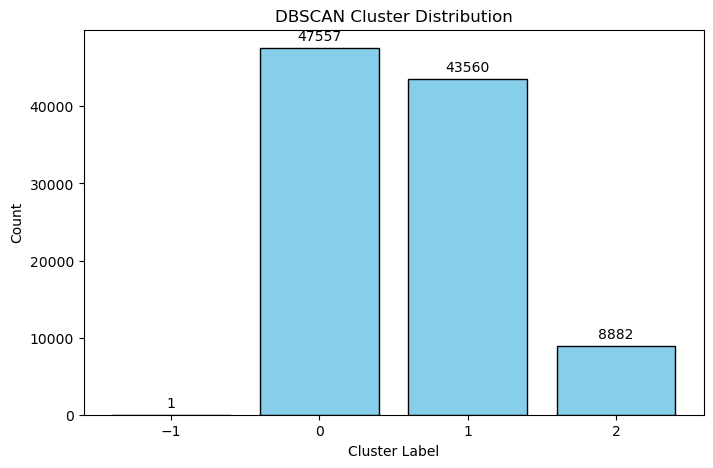

In [27]:
#ÏúÑÏùò Í≤∞Í≥º Í∑∏ÎûòÌîÑÌôî ÏãúÌÇ¥.

import matplotlib.pyplot as plt

# ÌÅ¥Îü¨Ïä§ÌÑ∞ Í∞úÏàò ÏÑ∏Í∏∞
cluster_counts = sampled_data["dbscan_cluster"].value_counts()

# ÎßâÎåÄÍ∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
plt.figure(figsize=(8, 5))
plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue', edgecolor='black')

# Í∑∏ÎûòÌîÑ Ï†úÎ™© Î∞è Î†àÏù¥Î∏î ÏÑ§Ï†ï
plt.title("DBSCAN Cluster Distribution")
plt.xlabel("Cluster Label")
plt.ylabel("Count")

# XÏ∂ï Í∞ÑÍ≤© 1 Îã®ÏúÑÎ°ú ÏÑ§Ï†ï
plt.xticks(np.arange(min(cluster_counts.index), max(cluster_counts.index) + 1, 1))

# Í∞í ÌëúÏãú
for i, count in enumerate(cluster_counts.values):
    plt.text(cluster_counts.index[i], count + 1000, str(count), ha='center', fontsize=10)

# Í∑∏ÎûòÌîÑ Ï∂úÎ†•
plt.show()


In [25]:
print(sampled_data.groupby("dbscan_cluster").mean())
#Î∂ÑÎ•òÎäî ÌñàÏúºÎÇò mean Í∞íÏù¥ Í∞ôÏúºÎ©¥ ÏùòÎØ∏ÏóÜÎäîÎç∞Ïù¥ÌÑ∞Îã§. Îã§ÌñâÌûà mean Í∞íÏù¥ Îã§Î•∏ ÌñâÏù¥ Î≥¥Ïù∏Îã§. 
# order_number : 1.0   days_since_prior_order :  999.0 Îäî Ïã†Í∑úÍ≥†Í∞ù Îç∞Ïù¥ÌÑ∞Îßå ÎΩëÏïÑÏôÄÏÑú Í∑∏Î†áÎã§.
#Ìï¥ÏÑùÏùÄ ÎßàÏßÄÎßâÏóê ÎßàÌÅ¨Îã§Ïö¥ÏúºÎ°ú ÏßÑÌñâÌï®.

                      user_id  order_number  days_since_prior_order  \
dbscan_cluster                                                        
-1              201268.000000           1.0                   999.0   
 0              103542.180794           1.0                   999.0   
 1              103330.786662           1.0                   999.0   
 2              103091.829768           1.0                   999.0   

                reorder_rate  total_products  cluster  
dbscan_cluster                                         
-1                  0.879195     3725.000000      2.0  
 0                  0.246231       57.762895      1.0  
 1                  0.574369      159.338912      0.0  
 2                  0.725580      686.987615      2.0  


### **üîç DBSCAN ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÌäπÏßï Î∂ÑÏÑù**  

Ïù¥Ï†ú ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Ï£ºÏöî Î≥ÄÏàòÏùò ÌèâÍ∑†Í∞íÏùÑ ÎπÑÍµêÌï¥ÏÑú **ÏùòÎØ∏ ÏûàÎäî Íµ∞ÏßëÌôîÍ∞Ä ÎêòÏóàÎäîÏßÄ** ÌôïÏù∏Ìï¥Î≥¥Ïûê.  

---

### **1Ô∏è‚É£ Ï£ºÏöî Ìå®ÌÑ¥ Î∂ÑÏÑù**
| ÌÅ¥Îü¨Ïä§ÌÑ∞ | Ï£ºÎ¨∏ ÌöüÏàò (`order_number`) | ÌèâÍ∑† Ï£ºÎ¨∏ Í∞ÑÍ≤© (`days_since_prior_order`) | Ïû¨Íµ¨Îß§Ïú® (`reorder_rate`) | Ï¥ù Ï£ºÎ¨∏ ÏÉÅÌíà (`total_products`) |
|----------|-----------------|-----------------------|---------------|---------------|
| **Cluster 0** | **1.0** | **999.0** | **0.246** | **57.76** |
| **Cluster 1** | **1.0** | **999.0** | **0.574** | **159.34** |
| **Cluster 2** | **1.0** | **999.0** | **0.726** | **686.99** |
| **Noise (-1)** | **1.0** | **999.0** | **0.879** | **3725.00** |

---

### **2Ô∏è‚É£ Î∂ÑÏÑù Î∞è Ìï¥ÏÑù**
1. **Î™®Îì† ÌÅ¥Îü¨Ïä§ÌÑ∞ÏóêÏÑú `order_number = 1.0`, `days_since_prior_order = 999.0`**
   - Ï¶â, **Î™®Îì† Ïú†Ï†ÄÍ∞Ä Ï≤´ Ï£ºÎ¨∏ÏùÑ ÌñàÍ≥†, 999(Í≤∞Ï∏°Í∞í)Î°ú Ï≤òÎ¶¨Îêú Ï£ºÎ¨∏ Í∞ÑÍ≤©ÏùÑ Í∞ÄÏßê.**  
   - Ïù¥Î•º Î≥¥Î©¥ DBSCANÏù¥ ÏÇ¨Ïã§ÏÉÅ **Ï£ºÎ¨∏ ÌöüÏàòÎÇò Ï£ºÎ¨∏ Í∞ÑÍ≤©ÏùÑ Í∏∞Î∞òÏúºÎ°ú Ìïú ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅÏù¥ ÏïÑÎãàÎùº, `reorder_rate`ÏôÄ `total_products` Ï§ëÏã¨ÏúºÎ°ú Íµ∞ÏßëÌôîÎêú Í≤É** Í∞ôÏùå.

2. **ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Ïû¨Íµ¨Îß§Ïú®(`reorder_rate`)Í≥º Ï¥ù Ï£ºÎ¨∏ ÏÉÅÌíà(`total_products`) ÎπÑÍµê**
   - `Cluster 0`: Ïû¨Íµ¨Îß§Ïú® 0.246, ÌèâÍ∑† Ï£ºÎ¨∏ ÏÉÅÌíà Ïàò 57.76 ‚Üí **ÎÇÆÏùÄ Ïû¨Íµ¨Îß§Ïú®, Ï†ÅÏùÄ Íµ¨Îß§Îüâ**  
   - `Cluster 1`: Ïû¨Íµ¨Îß§Ïú® 0.574, ÌèâÍ∑† Ï£ºÎ¨∏ ÏÉÅÌíà Ïàò 159.34 ‚Üí **Ï§ëÍ∞Ñ ÏàòÏ§Ä Ïû¨Íµ¨Îß§Ïú®, Ï§ëÍ∞Ñ Íµ¨Îß§Îüâ**  
   - `Cluster 2`: Ïû¨Íµ¨Îß§Ïú® 0.726, ÌèâÍ∑† Ï£ºÎ¨∏ ÏÉÅÌíà Ïàò 686.99 ‚Üí **ÎÜíÏùÄ Ïû¨Íµ¨Îß§Ïú®, ÎßéÏùÄ Íµ¨Îß§Îüâ**  
   - `Noise (-1)`: Ïû¨Íµ¨Îß§Ïú® 0.879, ÌèâÍ∑† Ï£ºÎ¨∏ ÏÉÅÌíà Ïàò 3725 ‚Üí **Í∞ÄÏû• ÎÜíÏùÄ Ïû¨Íµ¨Îß§Ïú®Í≥º Íµ¨Îß§ÎüâÏùÑ Í∞ÄÏßÑ ÌäπÏù¥Ïπò (VIP Í≥†Í∞ù?)**

---

### **3Ô∏è‚É£ Í≤∞Î°†: DBSCAN Í≤∞Í≥ºÎäî Ïú†ÏùòÎØ∏ÌïúÍ∞Ä?**
**‚úÖ ÏùòÎØ∏ ÏûàÎäî ÌÅ¥Îü¨Ïä§ÌÑ∞Ïùº Í∞ÄÎä•ÏÑ±Ïù¥ ÎÜíÏùå!**  
‚úî **Íµ¨Îß§ Ìå®ÌÑ¥Ïóê Îî∞Îùº ÌÅ¥Îü¨Ïä§ÌÑ∞Í∞Ä ÎÇòÎâòÏóàÏùå**:  
   - `Cluster 0` ‚Üí **ÏÜåÎüâ Íµ¨Îß§, ÎÇÆÏùÄ Ïû¨Íµ¨Îß§Ïú®**  
   - `Cluster 1` ‚Üí **Ï§ëÍ∞Ñ Ï†ïÎèÑ Íµ¨Îß§, Ï§ëÍ∞Ñ Ïû¨Íµ¨Îß§Ïú®**  
   - `Cluster 2` ‚Üí **ÎßéÏù¥ Íµ¨Îß§, ÎÜíÏùÄ Ïû¨Íµ¨Îß§Ïú®**  
   - `Noise (-1)` ‚Üí **Í∑πÎã®Ï†ÅÏúºÎ°ú ÎßéÏù¥ Íµ¨Îß§ÌïòÎäî VIP Í≥†Í∞ù**  

‚úî **DBSCANÏù¥ `order_number`ÎÇò `days_since_prior_order`Î≥¥Îã§Îäî `reorder_rate`ÏôÄ `total_products`Î•º Ï§ëÏã¨ÏúºÎ°ú Íµ∞ÏßëÌôîÌïú Í≤É Í∞ôÏùå**  
‚úî `eps` Í∞íÏóê Îî∞Îùº ÌÅ¥Îü¨Ïä§ÌÑ∞ Íµ¨ÏÑ±Ïù¥ Îã¨ÎùºÏßà Ïàò ÏûàÏùå ‚Üí **`eps=0.7` ~ `eps=1.2`Î°ú Ï∂îÍ∞Ä Ïã§Ìóò Í∞ÄÎä•**  

---

### **üöÄ Îã§Ïùå Ïï°ÏÖò Ï∂îÏ≤ú**
1. **ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ `reorder_rate`ÏôÄ `total_products` Î∂ÑÌè¨Î•º ÏãúÍ∞ÅÌôî**  
   - ÌûàÏä§ÌÜ†Í∑∏Îû® ÎòêÎäî Î∞ïÏä§ÌîåÎ°ØÏúºÎ°ú ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Î∂ÑÌè¨Î•º ÌôïÏù∏ÌïòÎ©¥ Îçî Î™ÖÌôïÌïú Ìå®ÌÑ¥ÏùÑ Î≥º Ïàò ÏûàÏùå.  

2. **eps Í∞í Ï°∞Ï†ï ÌõÑ Ï∂îÍ∞Ä Ïã§Ìóò**  
   - `eps=0.8` ÎòêÎäî `eps=1.2`Î°ú ÏÑ§Ï†ïÌï¥ÏÑú ÌÅ¥Îü¨Ïä§ÌÑ∞ Í∞úÏàòÍ∞Ä Ïñ¥ÎñªÍ≤å Î≥ÄÌïòÎäîÏßÄ ÌôïÏù∏.  

3. **ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Í≥†Í∞ù ÌñâÎèô Î∂ÑÏÑù**  
   - `Cluster 2`Îäî **Ï∂©ÏÑ± Í≥†Í∞ù**Ïùº Í∞ÄÎä•ÏÑ±Ïù¥ ÎÜíÍ≥†, `Cluster 0`ÏùÄ Ïù¥ÌÉà Í∞ÄÎä•ÏÑ±Ïù¥ ÎÜíÏùÄ Í∑∏Î£πÏùº ÏàòÎèÑ ÏûàÏùå.  
   - Í∞Å ÌÅ¥Îü¨Ïä§ÌÑ∞Ïóê ÎåÄÌïú **ÎßàÏºÄÌåÖ Ï†ÑÎûµ ÏàòÎ¶Ω Í∞ÄÎä•**.  


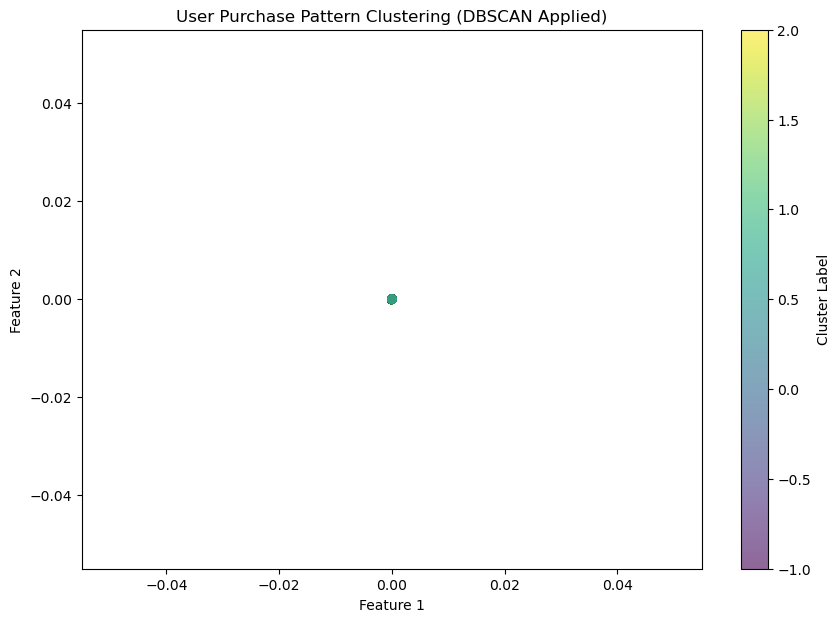

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


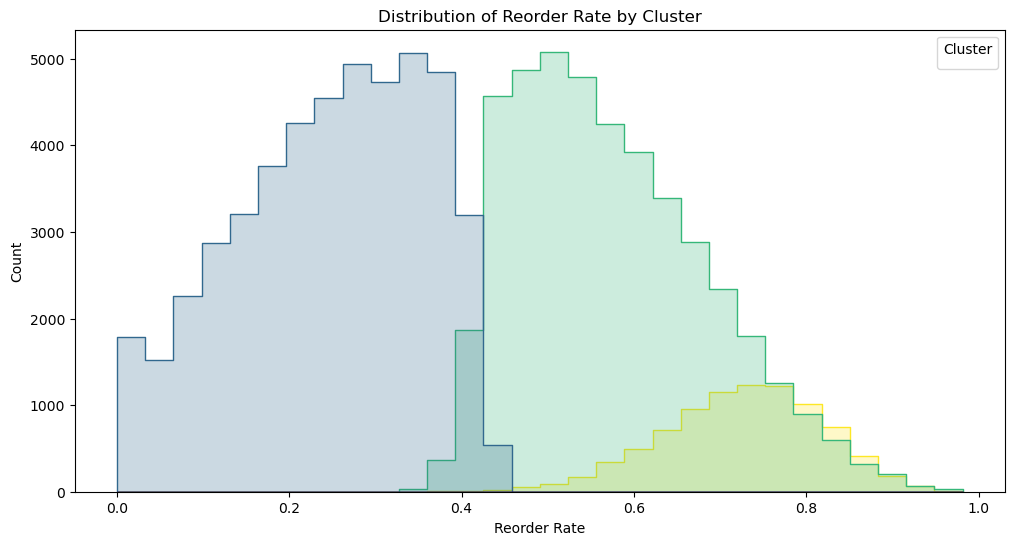

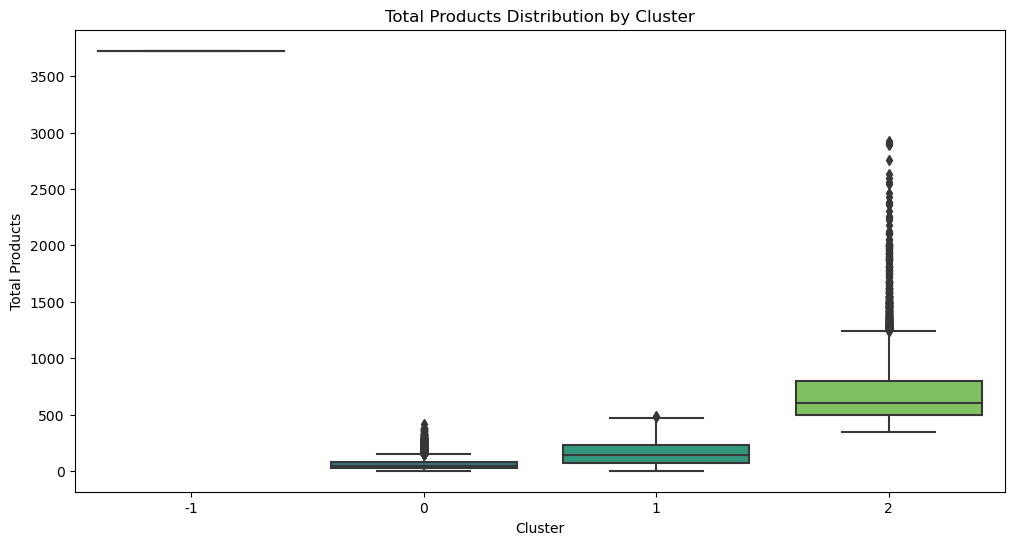

In [10]:
# ‚úÖ ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ Í≤∞Í≥º ÏãúÍ∞ÅÌôî (2D Scatter Plot)
plt.figure(figsize=(10, 7))
plt.scatter(sampled_scaled[:, 0], sampled_scaled[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("User Purchase Pattern Clustering (DBSCAN Applied)")
plt.colorbar(label="Cluster Label")
plt.show()

#Ïù¥Í±∞ ÏùòÎØ∏ÏóÜÎäî Í∑∏Î¶ºÏù¥Îã§.

# ‚úÖ ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ reorder_rate Î∂ÑÌè¨ (ÌûàÏä§ÌÜ†Í∑∏Îû®)
plt.figure(figsize=(12, 6))
sns.histplot(data=sampled_data, x="reorder_rate", hue="dbscan_cluster", element="step", palette="viridis", bins=30)
plt.xlabel("Reorder Rate")
plt.title("Distribution of Reorder Rate by Cluster")
plt.legend(title="Cluster")
plt.show()

#Ï∂îÏ≤ú Î∞õÏïÑÏÑú ÌñàÍ≥† ÎÇòÎ¶Ñ Í∑∏ÎûòÌîÑ Í∏∞Î∞òÏúºÎ°ú Ìï¥ÏÑùÌñàÎã§. ÏïÑÎûò ÎßàÌÅ¨Îã§Ïö¥Ïóê ÏûêÏÑ∏Ìï¥ Í∏∞Ïû¨ÌïòÏòÄÎã§. 1Î≤à Í∑∏ÎûòÌîÑÏù¥Îã§.

# ‚úÖ ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ total_products Î∂ÑÌè¨ (Î∞ïÏä§ÌîåÎ°Ø)
plt.figure(figsize=(12, 6))
sns.boxplot(data=sampled_data, x="dbscan_cluster", y="total_products", palette="viridis")
plt.xlabel("Cluster")
plt.ylabel("Total Products")
plt.title("Total Products Distribution by Cluster")
plt.show()

#Ï∂îÏ≤ú Î∞õÏïÑÏÑú ÌñàÍ≥† ÎÇòÎ¶Ñ Í∑∏ÎûòÌîÑ Í∏∞Î∞òÏúºÎ°ú Ìï¥ÏÑùÌñàÎã§. ÏïÑÎûò ÎßàÌÅ¨Îã§Ïö¥Ïóê ÏûêÏÑ∏Ìï¥ Í∏∞Ïû¨ÌïòÏòÄÎã§. 2 Î≤à Í∑∏ÎûòÌîÑÏù¥Îã§.


# Í∑∏ÎûòÌîÑ Í≤∞Í≥º. Ï†êÏúºÎ°ú ÌëúÌòÑÎêúÍ±∞ Ï†úÏô∏.
### **üîç Í∑∏ÎûòÌîÑ Î∂ÑÏÑù (ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ Íµ¨Îß§ Ìå®ÌÑ¥ Ï∞®Ïù¥)**

#### **1Ô∏è‚É£ Ïû¨Íµ¨Îß§Ïú® (`reorder_rate`) Î∂ÑÌè¨ Î∂ÑÏÑù**
- **ÌÅ¥Îü¨Ïä§ÌÑ∞ 0 (ÌååÎûÄÏÉâ)**  
  ‚Üí `reorder_rate`Í∞Ä Ï£ºÎ°ú **0~0.3 ÏÇ¨Ïù¥** ‚Üí **Ïû¨Íµ¨Îß§Ïú®Ïù¥ ÎÇÆÏùÄ Í≥†Í∞ù Í∑∏Î£π**  
  ‚Üí Ìïú Î≤à Ï£ºÎ¨∏ÌïòÍ≥† Îã§Ïãú Ï£ºÎ¨∏ÌïòÏßÄ ÏïäÎäî ÎπÑÏú®Ïù¥ ÎÜíÏùå.  
- **ÌÅ¥Îü¨Ïä§ÌÑ∞ 1 (Ï¥àÎ°ùÏÉâ)**  
  ‚Üí `reorder_rate`Í∞Ä **0.3~0.6 ÏÇ¨Ïù¥** ‚Üí **Ï§ëÍ∞Ñ ÏàòÏ§Ä Ïû¨Íµ¨Îß§Ïú®**  
  ‚Üí ÏùºÎ∂Ä Ï†úÌíàÏùÄ Î∞òÎ≥µÌï¥ÏÑú Íµ¨Îß§ÌïòÏßÄÎßå, Î™®Îì† Ï†úÌíàÏùÑ Ïû¨Íµ¨Îß§ÌïòÎäî Í≥†Í∞ùÏùÄ ÏïÑÎãò.  
- **ÌÅ¥Îü¨Ïä§ÌÑ∞ 2 (ÎÖ∏ÎûÄÏÉâ)**  
  ‚Üí `reorder_rate`Í∞Ä **0.6~0.9 ÏÇ¨Ïù¥** ‚Üí **Ïû¨Íµ¨Îß§Ïú®Ïù¥ ÎÜíÏùÄ Í≥†Í∞ù Í∑∏Î£π**  
  ‚Üí Ï†ïÍ∏∞Ï†ÅÏúºÎ°ú Íµ¨Îß§ÌïòÎäî Í≥†Í∞ù, Ï∂©ÏÑ±ÎèÑÍ∞Ä ÎÜíÏùÄ Í≥†Í∞ùÏùº Í∞ÄÎä•ÏÑ± ÌÅº.  

‚úÖ **Ìï¥ÏÑù:**  
- Í≥†Í∞ùÏùò Ïû¨Íµ¨Îß§ Ìå®ÌÑ¥Ïù¥ Î™ÖÌôïÌïòÍ≤å ÎÇòÎâòÏóàÏùå.  
- **ÌÅ¥Îü¨Ïä§ÌÑ∞ 0 ‚Üí Ïã†Í∑ú ÎòêÎäî ÏùºÌöåÏÑ± Íµ¨Îß§ Í≥†Í∞ù**  
- **ÌÅ¥Îü¨Ïä§ÌÑ∞ 1 ‚Üí ÏùºÎ∂Ä Ïû¨Íµ¨Îß§ Í≥†Í∞ù**  
- **ÌÅ¥Îü¨Ïä§ÌÑ∞ 2 ‚Üí ÏûêÏ£º Ïû¨Íµ¨Îß§ÌïòÎäî Ï∂©ÏÑ± Í≥†Í∞ù**  

---

#### **2Ô∏è‚É£ Ï¥ù Ï£ºÎ¨∏ ÏÉÅÌíà Ïàò (`total_products`) Î∞ïÏä§ÌîåÎ°Ø Î∂ÑÏÑù**
- **ÌÅ¥Îü¨Ïä§ÌÑ∞ 0 (Í∞ÄÏû• ÏôºÏ™Ω)**
  ‚Üí ÌèâÍ∑†Ï†ÅÏúºÎ°ú **50Í∞ú ÎØ∏Îßå**Ïùò ÏÉÅÌíàÏùÑ Íµ¨Îß§ ‚Üí **ÏÜåÎüâ Íµ¨Îß§ Í≥†Í∞ù**  
  ‚Üí ÏùºÎ∂Ä Ïù¥ÏÉÅÏπòÎäî ÏûàÏßÄÎßå, ÎåÄÏ≤¥Î°ú Ï†ÅÏùÄ ÏñëÏùò Ï†úÌíàÏùÑ Ï£ºÎ¨∏.  
- **ÌÅ¥Îü¨Ïä§ÌÑ∞ 1 (Í∞ÄÏö¥Îç∞)**
  ‚Üí ÌèâÍ∑†Ï†ÅÏúºÎ°ú **100~200Í∞ú ÎÇ¥Ïô∏** Íµ¨Îß§ ‚Üí **Ï§ëÍ∞Ñ Í∑úÎ™® Í≥†Í∞ù**  
  ‚Üí Îã§ÏñëÌïú Ï†úÌíàÏùÑ Íµ¨Îß§ÌïòÏßÄÎßå, ÎåÄÎüâ Ï£ºÎ¨∏ÏùÄ ÌïòÏßÄ ÏïäÏùå.  
- **ÌÅ¥Îü¨Ïä§ÌÑ∞ 2 (Ïò§Î•∏Ï™Ω, Ï¥àÎ°ùÏÉâ)**
  ‚Üí ÌèâÍ∑†Ï†ÅÏúºÎ°ú **500~700Í∞ú Ïù¥ÏÉÅ Íµ¨Îß§** ‚Üí **ÎåÄÎüâ Íµ¨Îß§ Í≥†Í∞ù**  
  ‚Üí Ïù¥ÏÉÅÏπò(Outlier)Í∞Ä ÎßéÏßÄÎßå, ÎåÄÎ∂ÄÎ∂ÑÏùò Í≥†Í∞ùÏù¥ Îã§Îüâ Íµ¨Îß§Î•º Ìï®.  

‚úÖ **Ìï¥ÏÑù:**  
- ÌÅ¥Îü¨Ïä§ÌÑ∞ 0: **ÏÜåÎüâ Íµ¨Îß§Ïûê (ÏÜåÍ∑úÎ™® ÏÜåÎπÑÏûê, ÌÖåÏä§Ìä∏ Ï£ºÎ¨∏ Í∞ÄÎä•ÏÑ±)**  
- ÌÅ¥Îü¨Ïä§ÌÑ∞ 1: **ÏùºÎ∞òÏ†ÅÏù∏ Í≥†Í∞ù (ÏùºÎ∞òÏ†ÅÏù∏ Ï†ïÍ∏∞ Íµ¨Îß§Ïûê)**  
- ÌÅ¥Îü¨Ïä§ÌÑ∞ 2: **ÎåÄÎüâ Íµ¨Îß§Ïûê (Í∏∞ÏóÖ ÎòêÎäî ÎèÑÎß§ ÏÜåÎπÑ Í∞ÄÎä•ÏÑ± ÎÜíÏùå)**  

---

### **üìå Í≤∞Î°†**
‚úî **ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥ÑÎ°ú ÌôïÏã§Ìïú Ìå®ÌÑ¥ Ï∞®Ïù¥Í∞Ä Ï°¥Ïû¨**  
‚úî **ÌÅ¥Îü¨Ïä§ÌÑ∞ 2(ÎÖπÏÉâ)Í∞Ä Ï∂©ÏÑ± Í≥†Í∞ù, ÌÅ¥Îü¨Ïä§ÌÑ∞ 0(ÌååÎûÄÏÉâ)Ïù¥ ÎÇÆÏùÄ Ï∂©ÏÑ±ÎèÑ Í≥†Í∞ùÏùº Í∞ÄÎä•ÏÑ± ÌÅº**  
‚úî **ÌÅ¥Îü¨Ïä§ÌÑ∞ 2Îäî Í∏∞ÏóÖ Í≥†Í∞ù, ÌÅ¥Îü¨Ïä§ÌÑ∞ 1ÏùÄ ÏùºÎ∞ò Í≥†Í∞ù, ÌÅ¥Îü¨Ïä§ÌÑ∞ 0ÏùÄ Ïã†Í∑ú Í≥†Í∞ùÏùº Í∞ÄÎä•ÏÑ±ÎèÑ ÏûàÏùå**  

üìå **Ïù¥Ï†ú Î≠ò ÌïòÎ©¥ Ï¢ãÏùÑÍπå?**  
üöÄ **ÎßàÏºÄÌåÖ Ï†ÑÎûµÏùÑ ÏÑ∏Ïö∏ Îïå Ïù¥Îü∞ Í≥†Í∞ù ÏÑ∏Î∂ÑÌôîÎ•º ÌôúÏö©Ìï† Ïàò ÏûàÏùå**  
üöÄ **ÌÅ¥Îü¨Ïä§ÌÑ∞Î≥Ñ ÎßûÏ∂§ Ï†ÑÎûµ ÌïÑÏöî: ÏòàÎ•º Îì§Ïñ¥, ÌÅ¥Îü¨Ïä§ÌÑ∞ 0 Í≥†Í∞ùÏùÑ ÌÅ¥Îü¨Ïä§ÌÑ∞ 1, 2Î°ú Ï†ÑÌôòÌïòÎäî Î∞©Î≤ï Í≥†ÎØº Í∞ÄÎä•**  


# Ïã†Í∑ú Í≥†Í∞ù Î∂ÑÏÑù_by Í≤ΩÎØºÎãò

In [ ]:
cur_dir = os.path.abspath(os.curdir)
data_dir = f"{cur_dir}/Modulabs_MainProject5"
files = [
    "orders.csv",
    "order_products__train.csv",
    "order_products__prior.csv",
    "df_products.csv"
]

df_orders, df_train, df_prior, df_products = [pd.read_csv(f"{data_dir}/{file}") for file in files]

In [ ]:
df_orders['days_since_prior_order'].isna().mean() * 100

In [ ]:
#first_purchaseÎùºÎäî Ï≤´Íµ¨Îß§ ÌôïÏù∏Ïö© Ïª¨Îüº Ï∂îÍ∞ÄÌïòÏó¨ days_since_prior_orderÍ∞Ä NaNÏù¥Î©¥ 1, ÏïÑÎãàÎ©¥ 0ÏùÑ Ï†ÄÏû•
df_orders["first_purchase"] = df_orders["days_since_prior_order"].isna().astype(int)

#ÌèâÍ∑†Í≥º Ï§ëÏïôÍ∞í ÌôïÏù∏
df_orders["days_since_prior_order"].describe().apply(lambda x: f"{x:,.2f}")

In [ ]:
# Îç∞Ïù¥ÌÑ∞ Î∂ÑÌè¨ ÌôïÏù∏
plt.hist(df_orders["days_since_prior_order"].dropna(), bins=30)
plt.xlabel("Days Since Prior Order")
plt.ylabel("Frequency")
plt.title("Distribution of days_since_prior_order")
plt.show()

0~10Ïùº ÏÇ¨Ïù¥Ïóê Ï£ºÎ¨∏Ïù¥ ÎßéÏùÄ Ìå®ÌÑ¥.  
**30Ïùº(Îß® ÎÅù Í∞í)**Ïóê ÎπàÎèÑ Í∏âÏ¶ù ‚Üí Ìïú Îã¨ Ï£ºÍ∏∞Î°ú Ï†ïÍ∏∞ Íµ¨Îß§ÌïòÎäî Í≥†Í∞ùÏù¥ ÎßéÎã§Îäî ÏùòÎØ∏Ïùº Í∞ÄÎä•ÏÑ±Ïù¥ ÌÅº.  
Îç∞Ïù¥ÌÑ∞Í∞Ä ÏôºÏ™ΩÏúºÎ°ú ÏπòÏö∞Ïπú ÎπÑÎåÄÏπ≠Ï†Å Î∂ÑÌè¨

In [ ]:
#ÎπÑÎåÄÏπ≠ Î∂ÑÌè¨Ïù¥ÎØÄÎ°ú Í≤∞Ï∏°Ïπò Ï§ëÏïôÍ∞íÏúºÎ°ú ÎåÄÏ≤¥
df_orders["days_since_prior_order"] = df_orders["days_since_prior_order"].fillna(df_orders["days_since_prior_order"].median())
df_orders

##Ï≤´ Íµ¨Îß§ Í≥†Í∞ù ÎπÑÏú® ÏãúÍ∞ÅÌôî

In [ ]:
first_purchase_ratio = df_orders["first_purchase"].mean() * 100
labels = ["First-time Customers", "Returning Customers"]
sizes = [first_purchase_ratio, 100 - first_purchase_ratio]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct="%.1f%%", startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title("First-time vs Returning Customers")
plt.show()

Ïû¨Íµ¨Îß§ Í≥†Í∞ùÏù¥ ÏïïÎèÑÏ†ÅÏúºÎ°ú ÎßéÏúºÎØÄÎ°ú Ïù¥Îì§Ïùò Ï∂©ÏÑ±ÎèÑÎ•º Í∞ïÌôîÌïòÎäî Í≤ÉÏù¥ ÌïµÏã¨  
Îã®, Ïã†Í∑ú Ïú†ÏûÖÏù¥ Ï†ÅÏùÄ Í≤ÉÏùÄ Ïû•Í∏∞Ï†Å Í¥ÄÏ†êÏóêÏÑú Ï∂©ÏÑ± Í≥†Í∞ùÏ∏µÏù¥ Ï§ÑÏñ¥Îì§ Í∞ÄÎä•ÏÑ± ÎÇ¥Ìè¨  
**ÏãúÏû• ÏßÄÎ∞∞Ï†Å ÏúÑÏπòÏù∏ÏßÄ ÌôïÏù∏ ÌïÑÏöî**. Í∑∏Î†áÏßÄ ÏïäÎã§Î©¥ Ï≤´ Íµ¨Îß§ Ïú†ÎèÑ ÎßàÏºÄÌåÖÎèÑ Í∞ïÌôîÌï† ÌïÑÏöîÍ∞Ä ÏûàÏùå

In [ ]:
# CSV ÌååÏùº ÏùΩÍ∏∞
df_comp = pd.read_csv("/content/drive/My Drive/GoogleTrends_Timeline.csv") 

#ÌååÏùº Í≤ΩÎ°ú Î≥ÄÍ≤Ω ÌïÑÏöî. Í≤ΩÎØºÎãòÏù¥ ÏßÅÏ†ë Ï∂îÏ∂úÌïú ÏûêÎ£åÏù∏Í≤ÉÏúºÎ°ú Î≥¥ÏûÑ.

In [ ]:
print(df_comp.columns)
df_comp.head()

df_comp["Date"] = pd.to_datetime(df_comp["Date"])  # ÎÇ†Ïßú ÌòïÏãù Î≥ÄÌôò
df_comp = df_comp[df_comp["Date"].between("2017-05-17", "2017-08-15")]

print(df_comp["Date"].max())
print(df_comp["Date"].min())

In [ ]:
# Í∑∏ÎûòÌîÑ ÌÅ¨Í∏∞ ÏÑ§Ï†ï
plt.figure(figsize=(12, 6))

# Instacart vs Í≤ΩÏüÅÏÇ¨ Í≤ÄÏÉâ Ìä∏Î†åÎìú ÏãúÍ∞ÅÌôî
plt.plot(df_comp["Date"], df_comp["Instacart"], marker="o", linestyle="-", label="Instacart", linewidth=2)
plt.plot(df_comp["Date"], df_comp["Amazon Fresh"], marker="s", linestyle="--", label="Amazon Fresh", linewidth=2)
plt.plot(df_comp["Date"], df_comp["Walmart Grocery"], marker="^", linestyle=":", label="Walmart Grocery", linewidth=2)

# Í∑∏ÎûòÌîÑ Ï†úÎ™© Î∞è ÎùºÎ≤® ÏÑ§Ï†ï
plt.xlabel("Date")
plt.ylabel("Search Interest")
plt.title("Instacart vs Competitors - Google Trends Comparison")
plt.legend()
plt.grid(True)

# Í∑∏ÎûòÌîÑ ÌëúÏãú
plt.xticks(rotation=45)
plt.show()


ÏûêÎ£å Ï†úÍ≥µ ÏãúÏ†ê(2017ÎÖÑ 5Ïõî ~ ÎèôÎÖÑ 8Ïõî)ÏóêÎäî Í≤ΩÏüÅÏÇ¨ ÎåÄÎπÑ ÎÇÆÏùÄ Í≤ÄÏÉâÎüâÏúºÎ°ú ÏãúÏû•Ïùò ÏßÄÎ∞∞ÏûêÎùºÍ≥† Î≥¥Í∏∞Îäî Ïñ¥Î†§ÏõÄ.  
 Í∑∏Îü¨ÎØÄÎ°ú Ïã†Í∑ú Ïú†ÏûÖÏùÑ ÏúÑÌïú Ï†ÑÎûµÎèÑ ÌïÑÏöîÌïòÎã§Í≥† ÏßêÏûëÌï† Ïàò ÏûàÏùå.

##Ï≤´ Íµ¨Îß§ Í≥†Í∞ùÏùò Ïù∏Í∏∞ Ï†úÌíà Î∂ÑÏÑù  
üëâ Ïã†Í∑ú Í≥†Í∞ùÏù¥ Ï≤òÏùå Íµ¨Îß§ÌïòÎäî Ï†úÌíàÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ï≤´ Íµ¨Îß§ Ïú†ÎèÑÎ•º ÏµúÏ†ÅÌôî  

üîπ Î∂ÑÏÑù Î∞©Î≤ï  
order_products__prior.csvÏùò reordered == 0 Îç∞Ïù¥ÌÑ∞Î•º ÌïÑÌÑ∞ÎßÅ  
Ï≤´ Íµ¨Îß§ÏóêÏÑú Í∞ÄÏû• ÎßéÏù¥ Íµ¨Îß§Ìïú Ï†úÌíà ÌôïÏù∏  
Ïù¥ Ï†úÌíàÎì§ÏùÑ Ïã†Í∑ú Í≥†Í∞ù Ìï†Ïù∏ ÌîÑÎ°úÎ™®ÏÖòÏóê Ìè¨Ìï®

In [ ]:
# Ï≤´ Íµ¨Îß§ Ï†úÌíà ÌïÑÌÑ∞ÎßÅ (reordered == 0)
first_purchase_products = df_prior[df_prior["reordered"] == 0]["product_id"].value_counts().reset_index()
first_purchase_products.columns = ["product_id", "first_purchase_count"]

# Ï†úÌíàÎ™Ö Ï∂îÍ∞Ä (df_products ÌôúÏö©)
top_5_products = first_purchase_products.head(5).merge(df[["product_id", "product_name"]], on="product_id", how="left")

# Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÌôïÏù∏ (ÏÉÅÏúÑ 5Í∞ú)
print(top_5_products)

# XÏ∂ïÏùÑ Ï†úÌíàÎ™ÖÏúºÎ°ú Î≥ÄÍ≤ΩÌïòÏó¨ Í∞ÄÎèÖÏÑ± Í∞úÏÑ†
plt.figure(figsize=(10, 5))
plt.bar(top_5_products["product_name"], top_5_products["first_purchase_count"], color='skyblue')

# ÎùºÎ≤® & Ï†úÎ™© Ï∂îÍ∞Ä
plt.xlabel("Product Name")
plt.ylabel("First Purchase Count")
plt.title("Top 5 First Purchased Products")

# XÏ∂ï ÎùºÎ≤® ÌöåÏ†Ñ (Í≤πÏπòÏßÄ ÏïäÎèÑÎ°ù)
plt.xticks(rotation=45, ha="right")

# Í∑∏ÎûòÌîÑ Ï∂úÎ†•
plt.show()

  Ìï¥Îãπ Ï†úÌíàÏùÑ Ïã†Í∑ú Í≥†Í∞ù Ìï†Ïù∏ Ï†úÌíàÏúºÎ°ú ÏÑ†Ï†ïÌïòÏó¨ **Ï≤´ Íµ¨Îß§ Ï†ÑÌôòÏú®**(Ïû†Ïû¨ Í≥†Í∞ù Ï§ëÏóêÏÑú Ïã§Ï†ú Íµ¨Îß§ÏûêÎ°ú Ï†ÑÌôòÎêú ÎπÑÏú®) Ï¶ùÍ∞ÄÏãúÌÇ§Îäî Î∞©Ìñ• Í≥†Î†§

##Ïã†Í∑ú Í≥†Í∞ùÏùò Ïû¨Íµ¨Îß§Ïú® Î∂ÑÏÑù
üëâ Ïã†Í∑ú Í≥†Í∞ùÏù¥ Ïû¨Íµ¨Îß§Î°ú Ï†ÑÌôòÎêòÎäî ÎπÑÏú®ÏùÑ Î∂ÑÏÑùÌïòÏó¨, Ï†ÑÌôò Ï†ÑÎûµ Í∞ïÌôî

üîπ Î∂ÑÏÑù Î∞©Î≤ï
df_ordersÏóêÏÑú Ï≤´ Ï£ºÎ¨∏(order_number == 1)Ïù∏ Í≥†Í∞ùÏùÑ Ï∞æÍ∏∞  
df_ordersÏóêÏÑú Ìï¥Îãπ Í≥†Í∞ùÎì§Ïùò Î™®Îì† Ï£ºÎ¨∏(user_id)ÏùÑ Í∞ÄÏ†∏Ïò§Í∏∞  
df_priorÏôÄ df_ordersÎ•º mergeÌïòÏó¨ Í≥†Í∞ùÏùò Ï£ºÎ¨∏ ÎÇ¥Ïó≠ÏùÑ user_id Í∏∞Ï§ÄÏúºÎ°ú ÌôïÏù∏  
Ïã†Í∑ú Í≥†Í∞ùÏù¥ Ïù¥ÌõÑÏóê Îã§Ïãú Ï£ºÎ¨∏ÌñàÎäîÏßÄ(reordered == 1 ÎπÑÏú® Í≥ÑÏÇ∞)

In [ ]:
# 1Ô∏è‚É£ Ïã†Í∑ú Í≥†Í∞ù Ï∞æÍ∏∞ (Ï≤´ Ï£ºÎ¨∏Îßå Ìïú Í≥†Í∞ù)
first_order_users = df_orders[df_orders['order_number'] == 1]['user_id'].unique()

# 2Ô∏è‚É£ Ïã†Í∑ú Í≥†Í∞ùÏùò Ï£ºÎ¨∏ Îç∞Ïù¥ÌÑ∞ Í∞ÄÏ†∏Ïò§Í∏∞ (df_ordersÏóêÏÑú user_id Í∏∞Ï§ÄÏúºÎ°ú ÌïÑÌÑ∞)
new_user_orders = df_orders[df_orders['user_id'].isin(first_order_users)]

# 3Ô∏è‚É£ df_priorÏôÄ df_ordersÎ•º order_id Í∏∞Ï§ÄÏúºÎ°ú merge (user_id Ï∂îÍ∞Ä)
df_prior_merged = df_prior.merge(new_user_orders[['order_id', 'user_id']], on='order_id', how='left')

# 4Ô∏è‚É£ Ïã†Í∑ú Í≥†Í∞ùÏù¥ Ï≤´ Ï£ºÎ¨∏ Ïù¥ÌõÑ Îã§Ïãú Íµ¨Îß§Ìïú ÎπÑÏú® (reordered == 1)
reorder_rate = df_prior_merged['reordered'].mean()

print(f"Ïã†Í∑ú Í≥†Í∞ùÏùò ÌèâÍ∑† Ïû¨Íµ¨Îß§Ïú®: {reorder_rate:.2%}")

# Ïã†Í∑ú Í≥†Í∞ùÏùò Ïû¨Íµ¨Îß§Ïú® Í≥ÑÏÇ∞
reorder_counts = df_prior_merged.groupby("reordered")["order_id"].count()
reorder_rate_values = reorder_counts / reorder_counts.sum()

# ÏõêÌòï Ï∞®Ìä∏ Í∑∏Î¶¨Í∏∞ (ÎπÑÏú® ÌëúÏãú)
plt.figure(figsize=(6, 6))
labels = ["New Order", "Reorder"]
colors = ["blue", "orange"]

plt.pie(reorder_rate_values, labels=labels, autopct="%1.2f%%", colors=colors, startangle=90, wedgeprops={"edgecolor": "white"})

plt.title("Distribution of Repeat Purchase Rate for New Customers (Proportion)")
plt.show()